#INITIALIZATION

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving SP500_data_fixed.xlsx to SP500_data_fixed.xlsx


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from scipy.stats import ks_2samp
from scipy.stats import skew, kurtosis
import python_utils as utils
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError
import random
import seaborn as sns
import tensorflow_probability as tfp
from scipy.stats import t as student_t
from tensorflow.keras import initializers
import textwrap
import os, datetime as dt
import tensorflow_probability as tfp
tfs = tfp.stats
from scipy.stats import wasserstein_distance
import pickle
import shutil, glob
from pathlib import Path

In [ ]:
file_path = "/content/SP500_data_fixed.xlsx" #insert your price file here
xls = pd.ExcelFile(file_path)

print(xls.sheet_names)

df = pd.read_excel(xls, sheet_name=0, index_col=0, parse_dates=True)

print(df.head())


selected_stocks = ["META", "TROW"] #select stocks

df = df[selected_stocks]

df = df.loc["2013-01-01":"2020-01-01"] #select timeframe

print(df.head())

# Save data
df.to_csv("meta_msft_2013_2019.csv") #adapt to your liking

csv_filename = "meta_msft_2013_2019.csv"
df.to_csv(csv_filename)
print(f"Data successfully saved to {csv_filename}")

['Stock Prices', 'Correlation Matrix']
            HPE       BSX  NCLH        MAS       OMC        MRK  ABNB  \
Date                                                                    
2000-01-03  NaN  11.50000   NaN  22.133127  48.43750  64.527672   NaN   
2000-01-04  NaN  11.68750   NaN  21.583920  46.84375  62.261452   NaN   
2000-01-05  NaN  12.53125   NaN  20.595343  45.50000  64.706581   NaN   
2000-01-06  NaN  12.87500   NaN  20.815025  45.75000  65.243324   NaN   
2000-01-07  NaN  12.40625   NaN  21.583920  47.68750  71.505249   NaN   

                  DUK      SNA      TROW  ...     AMGN     TDY  VLTO  SOLV  \
Date                                      ...                                
2000-01-03  42.057114  26.8750  17.56250  ...  62.9375  9.3750   NaN   NaN   
2000-01-04  42.710850  26.5625  17.03125  ...  58.1250  9.1250   NaN   NaN   
2000-01-05  44.454151  25.5625  17.00000  ...  60.1250  9.5000   NaN   NaN   
2000-01-06  45.652668  25.6250  17.50000  ...  61.1250  9.2

In [ ]:
file_path = "/content/SP500_data_fixed.xlsx"
xls = pd.ExcelFile(file_path)

print(xls.sheet_names)

df = pd.read_excel(xls, sheet_name=0, index_col=0, parse_dates=True)
selected_stocks = ["META", "TROW"]
df = df[selected_stocks]
df = df.loc["2013-01-01":"2020-01-01"]

# Compute log returns (stationary transformation)
df_log = np.log(df).diff().dropna()

# Save the processed data
csv_filename = "meta_msft_logreturns.csv"
df_log.to_csv(csv_filename)
print(f"Data saved to {csv_filename}")

# Check
print(df_log.head())

['Stock Prices', 'Correlation Matrix']
Data saved to meta_msft_logreturns.csv
                META      TROW
Date                          
2013-01-03 -0.008248  0.000149
2013-01-04  0.035029  0.019952
2013-01-07  0.022689 -0.000146
2013-01-08 -0.012312 -0.007050
2013-01-09  0.051311 -0.006061


In [ ]:
# Reset the index and drop the old index (Date column)
df_log.reset_index(drop=True, inplace=True)

# Now the DataFrame will be indexed by integers (0, 1, 2, ...)
print(df_log.head())

       META      TROW
0 -0.008248  0.000149
1  0.035029  0.019952
2  0.022689 -0.000146
3 -0.012312 -0.007050
4  0.051311 -0.006061


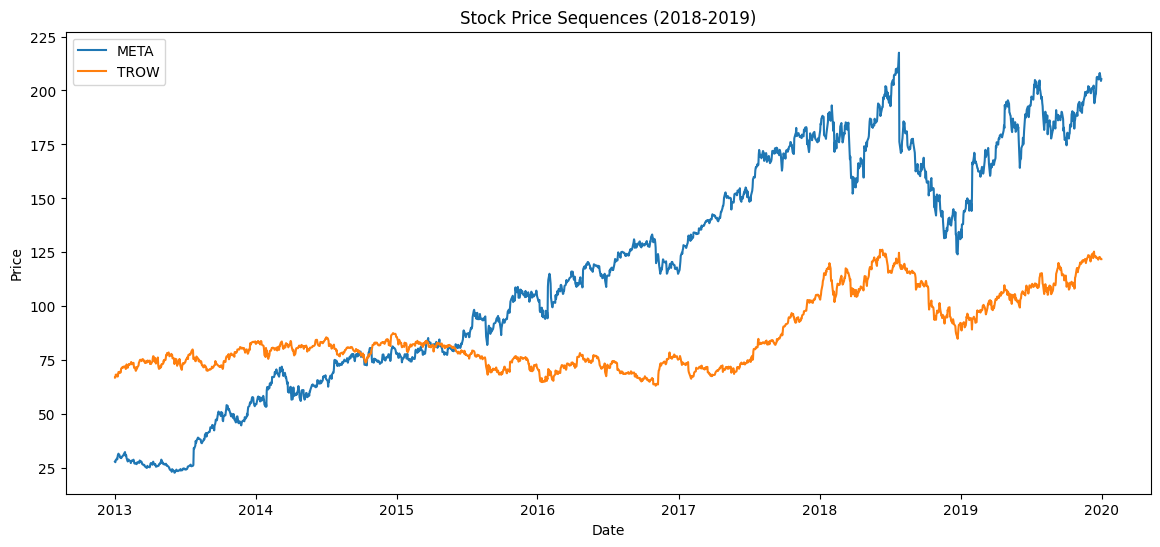

In [ ]:
plt.figure(figsize=(14, 6))
for stock in selected_stocks:
    plt.plot(df.index, df[stock], label=stock)

plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Stock Price Sequences (2018-2019)")
plt.legend()
plt.show()

In [ ]:
def load_and_preprocess(filename, seq_len):
    df = pd.read_csv(filename, index_col=0, parse_dates=True)
    df = df.sort_index()
    data = df.values

    sequences = []
    for i in range(len(data) - seq_len + 1):
        sequences.append(data[i:i + seq_len])
    sequences = np.array(sequences)
    return sequences

# Usage example
csv_file = "meta_msft_logreturns.csv"
seq_len = 120
ori_data = load_and_preprocess(csv_file, seq_len)
print("Shape of ori_data (log returns):", ori_data.shape)

Shape of ori_data (log returns): (1642, 120, 2)


In [ ]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.85
config.gpu_options.visible_device_list = "0"
session = InteractiveSession(config=config)

# Force TF to use non-CuDNN implementation
tf.config.experimental.enable_op_determinism()

#UTILITIES

In [ ]:
### Utility Functions ###
def train_test_divide (data_x, data_x_hat, data_t, data_t_hat, train_rate = 0.8):
  """Divide train and test data for both original and synthetic data.

  Args:
    - data_x: original data
    - data_x_hat: generated data
    - data_t: original time
    - data_t_hat: generated time
    - train_rate: ratio of training data from the original data
  """
  # Divide train/test index (original data)
  no = len(data_x)
  idx = np.random.permutation(no)
  train_idx = idx[:int(no*train_rate)]
  test_idx = idx[int(no*train_rate):]

  train_x = [data_x[i] for i in train_idx]
  test_x = [data_x[i] for i in test_idx]
  train_t = [data_t[i] for i in train_idx]
  test_t = [data_t[i] for i in test_idx]

  # Divide train/test index (synthetic data)
  no = len(data_x_hat)
  idx = np.random.permutation(no)
  train_idx = idx[:int(no*train_rate)]
  test_idx = idx[int(no*train_rate):]

  train_x_hat = [data_x_hat[i] for i in train_idx]
  test_x_hat = [data_x_hat[i] for i in test_idx]
  train_t_hat = [data_t_hat[i] for i in train_idx]
  test_t_hat = [data_t_hat[i] for i in test_idx]

  return train_x, train_x_hat, test_x, test_x_hat, train_t, train_t_hat, test_t, test_t_hat

def extract_time(data):
    """Returns Maximum sequence length and each sequence length.

  Args:
    - data: original data

  Returns:
    - time: extracted time information
    - max_seq_len: maximum sequence length
  """
    time = [len(seq) for seq in data]
    max_seq_len = max(time)
    return time, max_seq_len

def t_noise(shape, df=5, scale=0.6):
    """t(df) с единичной дисперсией * scale (0.5-0.7 обычно ок)."""
    sigma = np.sqrt(df/(df-2))        # σ исходного t
    return scale * student_t.rvs(df, size=shape) / sigma


def random_generator(batch_size, z_dim, T_mb, max_seq_len):
    """Generates a batch of random noise sequences."""
    Z_mb = np.zeros((batch_size, max_seq_len, z_dim))
    for i in range(min(batch_size, len(T_mb))):
        seq_length = T_mb[i]
        # Z_mb[i, :seq_length, :] = t.rvs(df=3, size=(seq_length, z_dim))
        Z_mb[i, :seq_length, :] = t_noise((seq_length, z_dim), df=5, scale=0.6)
        # Z_mb[i, :seq_length, :] = np.random.uniform(0., 1., (seq_length, z_dim))
    return Z_mb


def batch_generator(data, time, rolling_mu, rolling_sigma, batch_size):
    idx = np.random.permutation(len(data))[:batch_size]
    seq_lens = [time[i] for i in idx]
    max_len  = max(seq_lens)

    X_mb      = np.array([np.pad(seq[:l], ((0,max_len-l),(0,0)), mode='edge')
                          for l, seq in zip(seq_lens, data[idx])])
    mu_mb     = np.array([np.pad(rolling_mu[i][:l], ((0,max_len-l),(0,0)), 'edge')
                          for i,l in zip(idx, seq_lens)])
    sigma_mb  = np.array([np.pad(rolling_sigma[i][:l], ((0,max_len-l),(0,0)), 'edge')
                          for i,l in zip(idx, seq_lens)])
    return X_mb, seq_lens, mu_mb, sigma_mb



def exp_decay(initial, final, start_step, end_step, step):
    """
    Exponentially decays a weight from `initial` to `final`
    between [start_step, end_step].  Outside that window it is
    clamped to the respective edge value.
    """
    step = tf.cast(step, tf.float32)
    start_step = tf.cast(start_step, tf.float32)
    end_step   = tf.cast(end_step,   tf.float32)

    progress = tf.clip_by_value((step - start_step) / (end_step - start_step), 0.0, 1.0)
    log_interp = tf.math.log(initial) + progress * (tf.math.log(final) - tf.math.log(initial))
    return tf.exp(log_interp)

In [ ]:
class SNWrapper(tf.keras.layers.Wrapper):
    """
    Spectral Normalisation for every weight matrix in a layer,
    including recurrent_kernel for RNN cells.
    """
    def __init__(self, layer, power_iter: int = 1, **kwargs):
        super().__init__(layer, **kwargs)
        self.power_iter = power_iter
        self.w_refs, self.w_shapes, self.u_vecs = [], [], []
        self.current_sigma = None

    # -------------------------------------------------------------- #
    # locate kernels
    # -------------------------------------------------------------- #
    def build(self, input_shape):
        super().build(input_shape)

        def _add_kernel(w):
            if w is not None:
                self.w_refs.append(w)
                self.w_shapes.append(w.shape)
                self.u_vecs.append(
                    self.add_weight(
                        shape=(1, w.shape[-1]),
                        initializer="random_normal",
                        trainable=False,
                        name=f"sn_u_{len(self.u_vecs)}",
                    )
                )

        _add_kernel(getattr(self.layer, "kernel", None))

        cell = getattr(self.layer, "cell", None)
        if cell is not None:                       # LSTM/GRU wrapper
            _add_kernel(getattr(cell, "kernel", None))
            _add_kernel(getattr(cell, "recurrent_kernel", None))
        else:                                      # bare RNN cell
            _add_kernel(getattr(self.layer, "recurrent_kernel", None))

        if not self.w_refs:
            raise ValueError(f"No kernel found in layer {self.layer.name}")

    # -------------------------------------------------------------- #
    # spectral norm for a single matrix
    # -------------------------------------------------------------- #
    @staticmethod
    def _spectral_norm(w, u_var, power_iter):
        w_mat = tf.reshape(w, [-1, w.shape[-1]])
        u_hat = u_var
        for _ in range(power_iter):
            v_hat = tf.linalg.l2_normalize(tf.matmul(u_hat, w_mat, transpose_b=True))
            u_hat = tf.linalg.l2_normalize(tf.matmul(v_hat, w_mat))
        sigma = tf.matmul(tf.matmul(v_hat, w_mat), u_hat, transpose_b=True)
        u_var.assign(u_hat)
        return tf.reshape(w_mat / sigma, w.shape)

    # -------------------------------------------------------------- #
    # forward pass
    # -------------------------------------------------------------- #
    def call(self, inputs, training=None, **kwargs):
        originals = [tf.identity(w) for w in self.w_refs]   # <— fixed here

        for w, u in zip(self.w_refs, self.u_vecs):
            w.assign(self._spectral_norm(w, u, self.power_iter))

        out = self.layer(inputs, training=training, **kwargs)

        for w, w_orig in zip(self.w_refs, originals):
            w.assign(w_orig)

        return out

    def compute_output_shape(self, input_shape):
        return self.layer.compute_output_shape(input_shape)


In [ ]:
dim = ori_data.shape[2]  # Extract the number of features (columns)
max_seq_len = seq_len
z_dim = 8 # Latent space dimension

In [ ]:
parameters = {
    'hidden_dim': 64, # Number of hidden units in the RNN layers, was 64 in the best attempt
    'num_layer': 3, # Number of RNN layers
    'iterations': 20000, # Number of training iterations
    'batch_size': 64, # Size of each batch during training !!!!
    'z_dim': 8, # Latent space dimension
    'module': 'gru' # Define the RNN module ('lstm')
}

In [ ]:
# Network Parameters
hidden_dim = parameters['hidden_dim']
num_layers = parameters['num_layer']
iterations = parameters['iterations']
batch_size = parameters['batch_size']
module_name = parameters['module']
z_dim = parameters['z_dim']
gamma = 1

In [ ]:
class VolatilityScaler(tf.keras.layers.Layer):
    def __init__(self,
                 z_dim: int,
                 init_scale: float = 1.2,
                 init_sig: tf.Tensor | None = None):
        """
        Parameters
        ----------
        z_dim      : latent-feature dimensionality
        init_scale : fallback scale if `init_sig` is None
        init_sig   : 1-D tensor of length z_dim with the target
                     per-feature σ of real returns (may be NumPy
                     array – it is converted to tf.constant)
        """
        super().__init__()
        self.z_dim      = z_dim
        self.init_scale = init_scale
        self.init_sig   = (tf.constant(init_sig, dtype=tf.float32)
                           if init_sig is not None else None)

    def build(self, input_shape):
        assert len(input_shape) == 3 and input_shape[-1] == self.z_dim, \
            f"expected shape (batch, time, {self.z_dim})"

        if self.init_sig is not None:
            # Convert to numpy before using in initializer
            init_value = tf.math.log(self.init_sig)[None, None, :].numpy()
        else:
            # For scalar fallback, create numpy array directly
            init_value = tf.fill([1, 1, self.z_dim],
                              tf.math.log(self.init_scale)).numpy()

        self.log_scale = self.add_weight(
            name="log_scale",
            shape=(1, 1, self.z_dim),
            initializer=tf.constant_initializer(init_value),
            trainable=True,
        )

    def call(self, z):
        return z * tf.exp(self.log_scale)

In [ ]:
class SelfAttentionPooling(tf.keras.layers.Layer):
    def __init__(self, input_dim, **kwargs):
        super(SelfAttentionPooling, self).__init__(**kwargs)
        self.W = Dense(1, use_bias=False)

    def call(self, batch_rep):
        """
        Args:
            batch_rep: (batch_size, seq_len, hidden_dim)
        Returns:
            pooled_rep: (batch_size, hidden_dim)
        """
        # Compute attention weights
        att_scores = self.W(batch_rep)                    # (B,T,1)
        att_weights = tf.nn.softmax(att_scores, axis=1)   # (B,T,1)

        # Apply attention weights
        pooled_rep = tf.reduce_sum(batch_rep * att_weights, axis=1)  # (B,H)
        return pooled_rep

In [ ]:
class GGAN:
    def __init__(self, rolling_stats, **kwargs):
        super().__init__(**kwargs)
        self.rolling_stats = rolling_stats
        self.hidden_dim = parameters['hidden_dim']
        self.num_layers = parameters['num_layer']
        self.iterations = parameters['iterations']
        self.batch_size = parameters['batch_size']
        self.module_name = parameters['module']
        self.z_dim = parameters['z_dim']
        self.dim = 2  # Dimensionality of input data (e.g., two stocks)

        # Build all sub-models first
        self.embedder_model = self.build_embedder()
        self.recovery_model = self.build_recovery()
        self.generator_model = self.build_generator()
        self.supervisor_model = self.build_supervisor()
        self.discriminator_model = self.build_discriminator()

        # Define optimizers
        self.optimizer_E = tf.keras.optimizers.Adam(learning_rate=0.001)
        self.optimizer_R = tf.keras.optimizers.Adam(learning_rate=0.001)
        self.optimizer_S = tf.keras.optimizers.Adam(learning_rate=0.001)
        self.optimizer_G = tf.keras.optimizers.Adam(learning_rate=1e-4,
                                            beta_1=0.5, beta_2=0.9)
        self.optimizer_D = tf.keras.optimizers.RMSprop(learning_rate=1e-5)

        self.mse_loss = tf.keras.losses.MeanSquaredError()

        # Dummy initialization (after models are defined)
        print("Initializing model weights...")
        dummy_X = tf.random.normal([1, 60, self.dim])
        dummy_Z = tf.random.normal([1, 60, self.z_dim])
        dummy_H = tf.random.normal([1, 60, self.hidden_dim])
        _ = self.embedder_model(dummy_X)
        _ = self.recovery_model(dummy_H)
        _ = self.generator_model(dummy_Z)
        _ = self.supervisor_model(dummy_H)
        _ = self.discriminator_model(dummy_H)
        print("Model weights initialized.")

    def build_embedder(self):
        inputs = Input(shape=(None, self.dim))
        x = inputs
        for _ in range(self.num_layers):
            x = LSTM(self.hidden_dim, return_sequences=True)(x)
        outputs = Dense(self.hidden_dim, activation='linear')(x)
        return tf.keras.Model(inputs, outputs, name='Embedder')

    def build_recovery(self):
        inputs = tf.keras.Input((None, self.hidden_dim))
        x = inputs
        for _ in range(self.num_layers):
            x = tf.keras.layers.LSTM(self.hidden_dim,
                                  return_sequences=True,
                                  activation='swish')(x)  # Better gradient flow
        # Direct output without artificial scaling
        outputs = tf.keras.layers.Dense(self.dim, activation='linear')(x)
        return tf.keras.Model(inputs, outputs, name="Recovery")

    def build_generator(self):
        # Define input
        z_in = Input(shape=(None, self.z_dim))
        # Apply volatility scaling
        scaled_z = VolatilityScaler(self.z_dim)(z_in)
        x = scaled_z
        # Build LSTM layers
        for _ in range(self.num_layers):
            x = tf.keras.layers.LSTM(self.hidden_dim, return_sequences=True)(x)
        # Final output layer
        final_dense_layer = Dense(self.hidden_dim, activation=None)
        outputs = final_dense_layer(x)
        # Build model
        return tf.keras.Model(z_in, outputs, name='Generator')


    def build_supervisor(self):
        inputs = Input(shape=(None, self.hidden_dim))
        x = inputs
        for _ in range(self.num_layers - 1):
            x = LSTM(self.hidden_dim, return_sequences=True)(x)
        outputs = Dense(self.hidden_dim, activation='linear')(x)
        return tf.keras.Model(inputs, outputs, name='Supervisor')

    def build_discriminator(self):
        inputs = Input(shape=(None, self.hidden_dim))
        x = inputs
        for _ in range(self.num_layers):
            x = SNWrapper(
                tf.keras.layers.LSTM(self.hidden_dim, return_sequences=True,
                    activation='tanh', recurrent_activation='sigmoid', unroll=True),
                power_iter=1
            )(x)

        # Self-attention pooling
        pooled = SelfAttentionPooling(self.hidden_dim)(x)

        # Final classification
        outputs = SNWrapper(Dense(1, use_bias=False), power_iter=1)(pooled)
        return Model(inputs, outputs, name='Critic')

In [ ]:
# Extract time information at the beginning
ori_time, max_seq_len = extract_time(ori_data)

In [ ]:
def rolling_window_standardize(data, window=252):
    """

    Args:
        data: (num_sequences, seq_len, num_features) numpy array
        window: rolling window size

    Returns:
        standardized_data: same shape as input
        rolling_stats: statistics for descaling
    """
    num_sequences, seq_len, num_features = data.shape
    standardized_data = np.zeros_like(data)
    rolling_means = np.zeros_like(data)
    rolling_stds = np.zeros_like(data)

    for feat_idx in range(num_features):
        for seq_idx in range(num_sequences):
            # Convert to pandas Series for efficient rolling operations
            series = pd.Series(data[seq_idx, :, feat_idx])

            # Compute rolling statistics with minimum periods
            rolling_mean = series.rolling(window=window, min_periods=10).mean()
            rolling_std = series.rolling(window=window, min_periods=10).std()

            # Fill initial NaN values with expanding window
            rolling_mean = rolling_mean.fillna(series.expanding().mean())
            rolling_std = rolling_std.fillna(series.expanding().std())
            rolling_std = rolling_std.fillna(1e-8).clip(lower=1e-8)

            # Store statistics
            rolling_means[seq_idx, :, feat_idx] = rolling_mean.values
            rolling_stds[seq_idx, :, feat_idx] = rolling_std.values

            # Standardize
            standardized_data[seq_idx, :, feat_idx] = (
                (series - rolling_mean) / rolling_std
            ).values

    return standardized_data, {
        'means': rolling_means,
        'stds': rolling_stds
    }

In [ ]:
def preprocess_data_rolling(data, window=252, train_ratio=0.8):
    """
    Split data and apply rolling window standardization separately.

    Args:
        data: (num_sequences, seq_len, num_features) numpy array
        window: rolling window size for standardization
        train_ratio: fraction of data for training

    Returns:
        train_data: standardized training data
        test_data: standardized test data
        train_stats: rolling statistics for training data
        test_stats: rolling statistics for test data
    """
    # Split first, then standardize separately
    n_sequences = len(data)
    split_idx = int(n_sequences * train_ratio)

    train_raw = data[:split_idx]
    test_raw = data[split_idx:]

    # Apply rolling standardization separately
    train_data, train_stats = rolling_window_standardize(train_raw, window)
    test_data, test_stats = rolling_window_standardize(test_raw, window)

    return train_data, test_data, train_stats, test_stats

# Usage in your main pipeline
train_data, test_data, train_stats, test_stats = preprocess_data_rolling(
    ori_data, window=252, train_ratio=0.8
)

# Update your global variables
ori_data = np.concatenate([train_data, test_data], axis=0)
ori_time, max_seq_len = extract_time(ori_data)

In [ ]:
# ------------------------------------------------------------------
# rolling-stat tensors that every batch-generator call will re-use
# ------------------------------------------------------------------
roll_means = np.concatenate([train_stats['means'],  test_stats['means']], 0)
roll_stds  = np.concatenate([train_stats['stds'],   test_stats['stds']],  0)

rolling_stats = {
    "means": roll_means,   # shape (N, L, F)
    "stds" : roll_stds     # same shape
}

In [ ]:
def descale_rolling(x_scaled, rolling_stats, is_training=True):
    """
    Descale using rolling window statistics.

    Args:
        x_scaled: (batch_size, seq_len, num_features) scaled data
        rolling_stats: dict with 'means' and 'stds' arrays
        is_training: whether to use training or test statistics

    Returns:
        descaled data in original scale
    """
    stats_key = 'train' if is_training else 'test'
    means = rolling_stats[stats_key]['means']
    stds = rolling_stats[stats_key]['stds']


    if isinstance(x_scaled, tf.Tensor):
        means_tf = tf.constant(means, dtype=x_scaled.dtype)
        stds_tf = tf.constant(stds, dtype=x_scaled.dtype)

        batch_size = tf.shape(x_scaled)[0]
        means_tiled = tf.tile(tf.expand_dims(means_tf, 0), [batch_size, 1, 1])
        stds_tiled = tf.tile(tf.expand_dims(stds_tf, 0), [batch_size, 1, 1])

        return x_scaled * stds_tiled + means_tiled
    else:
        # NumPy version
        return x_scaled * stds + means

# Store rolling statistics globally for use in model
global_rolling_stats = {
    'train': train_stats,
    'test': test_stats
}

#FUNCTIONS DEFINITIONS

In [ ]:
@tf.function
def train_embedder(X_mb, T_mb):
    with tf.GradientTape() as tape:
        H = model.embedder_model(X_mb)  # Encode original data
        X_tilde = model.recovery_model(H)  # Decode back to original space
        E_loss_T0 = tf.reduce_mean(model.mse_loss(X_mb, X_tilde))  # Reconstruction Loss
        E_loss = 10 * tf.sqrt(E_loss_T0)  # Maintain loss scaling

    gradients = tape.gradient(E_loss,
                              model.embedder_model.trainable_variables +
                              model.recovery_model.trainable_variables)

    gradients, _ = tf.clip_by_global_norm(gradients, 0.5)  # Prevent exploding gradients

    # Apply gradient updates for both the embedder and recovery networks
    model.optimizer_E.apply_gradients(zip(gradients,
                                          model.embedder_model.trainable_variables +
                                          model.recovery_model.trainable_variables))

    return E_loss

In [ ]:
@tf.function
def train_embedder_step_joint(X_mb: tf.Tensor, T_mb: tf.Tensor) -> tf.Tensor:
    """
    Joint training embedder step (optional).
    We continue fine-tuning the embedder + recovery networks
    to improve reconstruction.
    """
    with tf.GradientTape() as tape:
        # Encode real data into H
        H = model.embedder_model(X_mb)
        # Decode back to original space
        X_tilde = model.recovery_model(H)
        # Reconstruction Loss
        E_loss_T0 = model.mse_loss(X_mb, X_tilde)
        # Scale up the embedder loss slightly
        E_loss = 10 * tf.sqrt(E_loss_T0 + 1e-9)

    # Compute gradients
    e_vars = model.embedder_model.trainable_variables + model.recovery_model.trainable_variables
    e_grads = tape.gradient(E_loss, e_vars)
    e_grads, _ = tf.clip_by_global_norm(e_grads, 0.5)

    # Apply gradients
    model.optimizer_E.apply_gradients(zip(e_grads, e_vars))

    return E_loss

In [ ]:
@tf.function
def train_supervised_step(X_mb, T_mb):
    """Train the supervisor network to predict next latent state."""
    with tf.GradientTape() as tape:
        H = model.embedder_model(X_mb)
        H_hat_supervise = model.supervisor_model(H)
        G_loss_S = tf.reduce_mean(tf.keras.losses.MeanSquaredError()(H[:, :-1, :], H_hat_supervise[:, 1:, :]))

    gradients = tape.gradient(G_loss_S, model.supervisor_model.trainable_variables)
    model.optimizer_S.apply_gradients(zip(gradients, model.supervisor_model.trainable_variables))
    return G_loss_S

In [ ]:
# ------------------------------------------------------------
# batched_acf
# ------------------------------------------------------------
@tf.function
def batched_acf(x, max_lag: int):
    """
    x : (B,T,F) float32/64
    returns tensor shape (max_lag, F) – ACF averaged over batch
    """
    B = tf.shape(x)[0]
    T = tf.shape(x)[1]
    F = tf.shape(x)[2]

    x_mean = tf.reduce_mean(x, axis=1, keepdims=True)
    xc     = x - x_mean
    var    = tf.reduce_mean(tf.square(xc), axis=1, keepdims=True)   # (B,1,F)
    var    = tf.maximum(var, 1e-8)


    ta = tf.TensorArray(dtype=x.dtype, size=max_lag, dynamic_size=False,
                        clear_after_read=False)

    T_f = tf.cast(T, x.dtype)

    def body(k, ta_):
        num = tf.reduce_sum(xc[:, :-k, :] * xc[:, k:, :], axis=1)           # (B,F)
        denom = (T_f - tf.cast(k, x.dtype)) * var[:, 0, :]                  # (B,F)
        ta_ = ta_.write(k-1, tf.reduce_mean(num / denom, axis=0))           # (F,)
        return k+1, ta_

    _, ta_final = tf.while_loop(
        lambda k, *_: k <= max_lag,
        body,
        loop_vars=(1, ta)
    )

    # stack -> (max_lag, F)
    return ta_final.stack()

In [ ]:
def tail_loss_two_sided(r_real, r_fake, q=0.05,
                        w_left=1., w_right=.5):
    rr = tf.reshape(r_real, [-1, tf.shape(r_real)[-1]])
    rf = tf.reshape(r_fake, [-1, tf.shape(r_fake)[-1]])

    # ---- VaR/ES of the REAL distribution only -----------------
    VaR_l = tfp.stats.percentile(rr, 100*q,      axis=0)
    VaR_r = tfp.stats.percentile(rr, 100*(1-q),  axis=0)

    ES_r_l = tf.reduce_mean(tf.boolean_mask(rr, rr <= VaR_l), axis=0)
    ES_f_l = tf.reduce_mean(tf.boolean_mask(rf, rf <= VaR_l), axis=0)  # <-- SAME threshold

    ES_r_r = tf.reduce_mean(tf.boolean_mask(rr, rr >= VaR_r), axis=0)
    ES_f_r = tf.reduce_mean(tf.boolean_mask(rf, rf >= VaR_r), axis=0)  # <-- SAME threshold

    sig = tf.math.reduce_std(rr, axis=0) + 1e-8          # real σ

    loss_left  = tf.square((ES_r_l - ES_f_l) / sig)
    loss_right = tf.square((ES_r_r - ES_f_r) / sig)

    return tf.reduce_mean(w_left*loss_left + w_right*loss_right)

In [ ]:
# ------------------------------------------------------------
# heteroskedasticity loss
# ------------------------------------------------------------
def heteroskedasticity_loss(real_r: tf.Tensor, fake_r: tf.Tensor, window: int = 20):
    """L1 difference of rolling σ  +  ACF of squared returns."""
    real_vol = rolling_std(real_r, window)
    fake_vol = rolling_std(fake_r, window)
    vol_loss = tf.reduce_mean(tf.abs(real_vol - fake_vol))

    real_sq, fake_sq = tf.square(real_r), tf.square(fake_r)
    real_acf = batched_acf(real_sq, 10)
    fake_acf = batched_acf(fake_sq, 10)
    cluster_loss = tf.reduce_mean(tf.square(real_acf - fake_acf))
    return vol_loss + cluster_loss

In [ ]:
def descale_time_varying(x_scaled, mu, sigma):
    return x_scaled * sigma + mu

In [ ]:
import tensorflow as tf

# ------------------------------------------------------------
# helper: rolling std (mask‑aware 1‑D pooling)
# ------------------------------------------------------------

def rolling_std(x: tf.Tensor, win: int, mask: tf.Tensor = None):
    """Causal rolling σ over last *win* steps.
    If *mask* is supplied (shape == x), treats 0s as missing.
    Args
    -----
    x    : (B,T,F) float32/64  – returns in real space
    win  : int                  – window length
    mask : (B,T,1|F) or None   – 0/1 mask
    """
    if mask is None:
        mask = tf.ones_like(x)
    w   = tf.cast(mask, x.dtype)
    num = tf.nn.avg_pool1d(x * w, win, 1, "SAME", data_format="NWC")
    den = tf.nn.avg_pool1d(w,      win, 1, "SAME", data_format="NWC") + 1e-8
    mean = num / den
    var  = tf.nn.avg_pool1d(w * tf.square(x - mean), win, 1, "SAME", data_format="NWC") / den
    return tf.sqrt(var + 1e-7)
# ------------------------------------------------------------
# UPDATED train_generator_step  (TimeGAN generator + supervisor)
# ------------------------------------------------------------

@tf.function
def train_generator_step(
    X_mb: tf.Tensor,          # (B,T,F)  scaled real log‑returns
    T_mb: tf.Tensor,          # (B,)     true lengths
    Z_mb: tf.Tensor,          # (B,T,z)  latent noise
    mu_mb,       # (B,T,F) rolling means
    sig_mb,      # (B,T,F) rolling stds
    *,
    step: tf.Tensor,          # global step (int32/int64)
    roll_window: int = 25,
):
    # ————————————————— weights (tune as you like) —————————————————
    w_S, w_V      = 10.0, 10.0
    w_mu, w_tail  = 15.0, 15.0
    w_sigma, w_vol= 10.0, 20.0
    w_acf, w_het  = 15.0, 20.0

    mask = tf.expand_dims(tf.sequence_mask(T_mb, tf.shape(X_mb)[1], dtype=X_mb.dtype), -1)

    with tf.GradientTape() as tape:
        # ---- forward ----
        H_real = model.embedder_model(X_mb, training=False)
        E_hat  = model.generator_model(Z_mb, training=True)
        H_hat  = model.supervisor_model(E_hat, training=True)
        H_sup  = model.supervisor_model(H_real, training=False)
        Y_fake = model.discriminator_model(H_hat, training=False)
        r_fake_scaled = model.recovery_model(H_hat, training=False) * mask

        # --------- inverse-scale with time-varying stats ------------
        r_real = descale_time_varying(X_mb*mask,  mu_mb,  sig_mb)
        r_fake = descale_time_varying(r_fake_scaled, mu_mb, sig_mb)

        # ===== losses =====
        # TimeGAN core
        G_loss_U = -tf.reduce_mean(Y_fake)
        G_loss_S = tf.sqrt(tf.reduce_mean(tf.keras.losses.mse(H_real[:,1:,:], H_sup[:,:-1,:])))
        G_loss_V = (tf.reduce_mean(tf.abs(tf.math.reduce_std(H_hat,0) - tf.math.reduce_std(H_real,0))) +
                     tf.reduce_mean(tf.abs(tf.reduce_mean(H_hat,0) - tf.reduce_mean(H_real,0))))

        # mean‑matching, VaR/ES, global σ
        mu_r = tf.reduce_mean(r_real, axis=[0,1]); mu_f = tf.reduce_mean(r_fake, axis=[0,1])
        L_mu = tf.reduce_mean(tf.square(mu_r - mu_f))
        Tail_main = tail_loss_two_sided(r_real, r_fake, q=0.05, w_left=1.5, w_right=1.0)
        sigma_r = tf.math.reduce_std(r_real); sigma_f = tf.math.reduce_std(r_fake)
        margin = 1.1
        L_sigma = tf.where(sigma_f > sigma_r*margin,
                           (sigma_f-sigma_r)/sigma_r,
                           (sigma_r*margin-sigma_f)/(sigma_r*0.5))
        L_sigma = tf.reduce_mean(L_sigma)

        # rolling σ + ACF
        L_vol = tf.reduce_mean(tf.abs(rolling_std(r_real,roll_window,mask) -
                                       rolling_std(r_fake,roll_window,mask)))

        acf_real = batched_acf(r_real, 20); acf_fake = batched_acf(r_fake, 20)
        acf_weights = tf.concat([[2.], tf.ones([19])],0)
        L_acf = tf.reduce_mean(tf.abs(acf_real - acf_fake) * acf_weights[:,None,None])


        # NEW heteroskedasticity term
        L_het = heteroskedasticity_loss(r_real, r_fake, window=20)

        # scale-free diagnostics
        dmu_over_sig = tf.reduce_mean(tf.abs(mu_r - mu_f) /
                                      (sigma_r + 1e-8))
        sig_ratio    = tf.reduce_mean(sigma_f / (sigma_r + 1e-8))


        # total
        G_total = (G_loss_U + w_S*G_loss_S + w_V*G_loss_V + w_mu*L_mu + w_tail*Tail_main +
                    w_sigma*L_sigma + w_vol*L_vol + w_acf*L_acf + w_het*L_het)

    vars_G = model.generator_model.trainable_variables + model.supervisor_model.trainable_variables
    grads  = tape.gradient(G_total, vars_G)

    model.optimizer_G.apply_gradients(zip(grads, vars_G))

    return (G_total,
         G_loss_U,  G_loss_S,  G_loss_V,
         L_mu, Tail_main, L_sigma,
         L_vol, L_acf, L_het,
         dmu_over_sig, sig_ratio
    )


In [ ]:
@tf.function
def generator_warmup_step(X_mb, T_mb, Z_mb,
                          w_S = 10.0,
                          w_sig = 6.0,
                          w_mu = 2.0):
    """
    Pre-train G+S without the critic.
      • matches next-step dynamics  (G_loss_S)
      • matches mean / std of latent codes  (G_loss_V)
    """

    with tf.GradientTape() as tape:
        # ---------- latent paths ---------------------------------
        H_real = tf.stop_gradient(model.embedder_model(X_mb))          # frozen E
        E_hat  = model.generator_model(Z_mb)
        H_hat  = model.supervisor_model(E_hat)

        # ---------- losses ---------------------------------------
        # (1) supervised – next latent step
        G_loss_S = tf.reduce_mean(
            tf.keras.losses.MSE(H_real[:, 1:, :], H_hat[:, :-1, :]))

        mu_r  = tf.reduce_mean(H_real, axis=[0,1])
        mu_f  = tf.reduce_mean(H_hat,  axis=[0,1])
        std_r = tf.math.reduce_std(H_real, axis=[0,1]) + 1e-6   # avoid /0

        loss_mu  = tf.reduce_mean(tf.abs((mu_r - mu_f) / std_r))      # scale-free
        loss_std = tf.reduce_mean(tf.abs(
                     tf.math.reduce_std(H_real, axis=[0,1]) -
                     tf.math.reduce_std(H_hat, axis=[0,1])))
        G_total = w_S * G_loss_S + w_mu * loss_mu + w_sig * loss_std


    # ---------- parameter update --------------------------------
    vars_GS = (model.generator_model.trainable_variables +
               model.supervisor_model.trainable_variables)
    grads    = tape.gradient(G_total, vars_GS)
    model.optimizer_G.apply_gradients(zip(grads, vars_GS))

    return G_loss_S, loss_mu, loss_std

In [ ]:
@tf.function
def train_discriminator_step(X_mb, Z_mb):
    """
    One critic update under the WGAN-SN setting.
    Only the discriminator’s weights receive gradients.
    """

    with tf.GradientTape() as disc_tape:
        # ---------- real latent path ---------------------------------
        H_real = tf.stop_gradient(model.embedder_model(X_mb))              # embedder is *frozen*
        Y_real = model.discriminator_model(H_real)


        # ---------- fake latent path  (GRADIENTS STOPPED here) -------
        E_hat  = tf.stop_gradient(model.generator_model(Z_mb))
        H_fake = tf.stop_gradient(model.supervisor_model(E_hat))
        Y_fake = model.discriminator_model(H_fake)

        # ---------- Wasserstein loss ---------------------------------
        D_loss = tf.reduce_mean(Y_fake) - tf.reduce_mean(Y_real)


    grads = disc_tape.gradient(
        D_loss, model.discriminator_model.trainable_variables
    )


    model.optimizer_D.apply_gradients(
        zip(grads, model.discriminator_model.trainable_variables)
    )
    return D_loss

In [ ]:
def warmup_discriminator_step(X_mb, Z_mb):
    """
    One pre-training step for the critic under the WGAN-SN setting.
    Uses raw critic scores (no sigmoid) and Wasserstein loss.
    """

    #-----------------------------------------------------------#
    # IMPORTANT: detach generator path so its weights are frozen
    #           during the critic warm-up / update.
    #-----------------------------------------------------------#
    with tf.GradientTape() as disc_tape:
        # ----- real path --------------------------------------
        # H_real = model.embedder_model(X_mb) # latent of real data
        H_real = tf.stop_gradient(model.embedder_model(X_mb))
        Y_real = model.discriminator_model(H_real)       # critic scores

        # ----- fake path  (stop gradients into G,S) ----------
        H_fake = model.supervisor_model(model.generator_model(Z_mb))
        H_fake = tf.stop_gradient(H_fake)                # <-- freeze G & S
        Y_fake = model.discriminator_model(H_fake)

        # ----- Wasserstein critic loss -----------------------
        D_loss = tf.reduce_mean(Y_fake) - tf.reduce_mean(Y_real)


    # ----- critic parameter update ---------------------------
    disc_gradients = disc_tape.gradient(
        D_loss, model.discriminator_model.trainable_variables
    )
    model.optimizer_D.apply_gradients(
        zip(disc_gradients, model.discriminator_model.trainable_variables)
    )

    return D_loss

In [ ]:
train_time, _ = extract_time(train_data)
test_time , _ = extract_time(test_data)
_, max_seq_len = extract_time(train_data)        # or use a constant

In [ ]:
# sc_means = tf.constant([float(s.mean_)  for s in scalers], dtype=tf.float32)
# sc_stds  = tf.constant([float(s.scale_) for s in scalers], dtype=tf.float32)
# # shapes are now (F,)

In [ ]:
# ------------------------------------------------------------
#  Improved monitoring utilities
# ------------------------------------------------------------

# ---------- helper: 1-D autocorrelation ----------------------
def autocorr_1d(x, max_lag=20):
    """Return ACF[0…max_lag] of a 1-D NumPy array."""
    x = x - x.mean()
    var = x.var() + 1e-12
    acf = [1.0]
    for k in range(1, max_lag + 1):
        acf.append(np.dot(x[:-k], x[k:]) / ((len(x) - k) * var))
    return np.array(acf)          # shape (max_lag+1,)

# ---------- helper: Wasserstein averaged over time ----------
def wasserstein_over_time(real, fake):
    """
    real, fake : (N, L, F) – sequences must share the same length.
    Computes EMD at each time step t and averages over t.
    """
    assert real.shape[1] == fake.shape[1], "sequence length mismatch"
    ws = []
    for t in range(real.shape[1]):
        # flatten (N, F) -> (N*F,) at this time step
        r_t = real[:, t, :].reshape(-1)
        f_t = fake[:, t, :].reshape(-1)
        ws.append(wasserstein_distance(r_t, f_t))
    return np.mean(ws)

# ------------------------------------------------------------
class DistributionMonitor:
    def __init__(self, real_data, rolling_stats, max_lag=20):
        self.real_data = real_data         # still kept in **scaled** form
        self.mu   = rolling_stats['means']
        self.sig  = rolling_stats['stds']
        self.max_lag   = max_lag
        self.metrics   = {"wasserstein": [],
                          "acf_diff"   : [],
                          "var_ratio"  : [],
                          "grad_norm": []}

    # ---------- public ---------------------------------------------------
    def analyze(self, synthetic, step):
        # ① inverse-scale -------------------------------------------------
        real = self.inverse_transform(self.real_data)
        fake = self.inverse_transform(synthetic)

        # ② metrics -------------------------------------------------------
        self.metrics["wasserstein"].append(wasserstein_over_time(real, fake))
        self.metrics["acf_diff"   ].append(self.acf_comparison(real, fake))
        var_real = np.percentile(real, 5, axis=(0, 1))
        var_fake = np.percentile(fake, 5, axis=(0, 1))
        self.metrics["var_ratio"  ].append(np.mean(var_fake / (var_real + 1e-8)))


        # ③ optional visual snapshot -------------------------------------
        self.plot_distributions(real, fake, step)

    def log_grad_norm(self, grad_norm, step):
        self.metrics["grad_norm"].append(grad_norm)

    # --------------------------------------------------------- #
    # FIXED inverse_transform -- put this in place of the old one
    # --------------------------------------------------------- #
    def inverse_transform(self, data):
        return data * self.sig + self.mu

    def acf_comparison(self, real, fake):
        """
        Average |ACF_real − ACF_fake| over all features & sequences.
        Uses the first 100 sequences for speed.
        """
        max_lag = self.max_lag
        def batch_acf(arr):
            seq_sub = arr[:100]                     # (≤100, L, F)
            acfs = []
            for seq in seq_sub:
                for f in range(seq.shape[1]):
                    acfs.append(autocorr_1d(seq[:, f], max_lag))
            return np.stack(acfs).mean(axis=0)      # shape (max_lag+1,)
        return np.mean(np.abs(batch_acf(real) - batch_acf(fake)))

    # ---------- pretty picture ------------------------------------------
    def plot_distributions(self, real, fake, step):
        plt.figure(figsize=(12, 4))

        # left: global histogram
        plt.subplot(121)
        sns.histplot(real.ravel(), kde=True, label="Real", stat="density")
        sns.histplot(fake.ravel(), kde=True, label="Fake", stat="density",
                     alpha=0.7)
        plt.legend(); plt.title(f"Step {step} – Value distribution")

        # right: averaged ACF curves
        plt.subplot(122)
        lags = np.arange(1, self.max_lag + 1)
        acf_r = self._avg_acf(real)
        acf_f = self._avg_acf(fake)
        plt.plot(lags, acf_r[1:], label="Real")
        plt.plot(lags, acf_f[1:], label="Fake")
        plt.xlabel("Lag"); plt.ylabel("ACF"); plt.legend()
        plt.title("Mean autocorrelation")

        plt.tight_layout()
        fig_name = FIG_DIR / f"dist_comparison_step_{step}.png"
        plt.savefig(f"dist_comparison_step_{step}.png")
        plt.close()

    def _avg_acf(self, data):
        """Helper used only for plotting."""
        seq_sub = data[:100]
        acfs = []
        for seq in seq_sub:
            for f in range(seq.shape[1]):
                acfs.append(autocorr_1d(seq[:, f], self.max_lag))
        return np.stack(acfs).mean(axis=0)

In [ ]:
# ------------------------------------------------------------
def plot_metrics(metrics):
    """Call once in a while to update the global metric curves."""
    plt.figure(figsize=(15, 4))

    n_plots = len(metrics)
    for i, (name, vals) in enumerate(metrics.items(), 1):
        plt.subplot(1, n_plots, i)
        plt.plot(vals)
        plt.title(name.replace("_", " ").title())
        plt.xlabel("Checkpoint idx")

    plt.tight_layout()
    plt.savefig("training_metrics.png")
    plt.close()

In [ ]:
@tf.function
def critic_grad_norm(x_real):
    with tf.GradientTape() as tape:
        tape.watch(x_real)  # Watch the input tensor
        h = model.embedder_model(x_real)  # latent representation
        y = model.discriminator_model(h)
    grads = tape.gradient(y, h)  # Gradient of critic output wrt latent h
    # Compute L2 norm over batch and time dimensions: shape (batch, time, features)
    grad_norms = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]) + 1e-8)
    # Return average grad norm over batch
    return tf.reduce_mean(grad_norms)

In [ ]:
def generate_synthetic_samples(model,
                               n_samples: int,
                               ref_real: np.ndarray,
                               max_len: int):
    """
    Create `n_samples` synthetic sequences.

    Parameters
    ----------
    model      : your TimeGAN instance
    n_samples  : how many sequences you want back
    ref_real   : a *real* dataset of shape (N, L, F) –
                 only used for their individual lengths
    max_len    : integer, padding length you used in `random_generator`

    Returns
    -------
    np.ndarray of shape (n_samples, L_i, F) – the same
    per-sequence lengths as in `ref_real[:n_samples]`
    """
    # 1) grab the first n length values from whatever set you pass in
    seq_lens = [len(seq) for seq in ref_real[:n_samples]]

    synthetic_chunks = []
    for i in range(0, n_samples, model.batch_size):
        batch_lens = seq_lens[i : i + model.batch_size]

        # build noise that matches those lengths
        Z_mb = random_generator(len(batch_lens),
                                model.z_dim,
                                batch_lens,
                                max_len)

        # forward through G → S → R
        E_hat = model.generator_model(Z_mb, training=False)
        H_hat = model.supervisor_model(E_hat, training=False)
        X_hat = model.recovery_model(H_hat, training=False)

        synthetic_chunks.append(X_hat.numpy())

    return np.concatenate(synthetic_chunks, axis=0)[:n_samples]

In [ ]:
@tf.function
def critic_gap_no_grad(x_real, z_noise):
    """ E[D_real] − E[D_fake]  (no gradients). """
    h_r = tf.stop_gradient(model.embedder_model(x_real))
    h_f = tf.stop_gradient(model.supervisor_model(
                               model.generator_model(z_noise)))
    d_r = model.discriminator_model(h_r, training=False)
    d_f = model.discriminator_model(h_f, training=False)
    return tf.reduce_mean(d_r) - tf.reduce_mean(d_f)

In [ ]:
def adjust_critic_lr(gap: float, gen_grad: float,
                     opt: tf.keras.optimizers.Optimizer,
                     lr_min: float = 1e-5, lr_max: float = 3e-5):

    lr_now = opt.learning_rate.numpy()

    if gap < -0.1:
        lr_new = max(lr_min, 0.7 * lr_now)
    elif gap < 0.0:
        lr_new = max(lr_min, 0.9 * lr_now)
    elif gap > 5.0:                       # <- optional emergency brake
        lr_new = max(lr_min, 0.5 * lr_now)
    elif gap > 0.2 and gen_grad < 2.0:
        lr_new = min(lr_max, 1.1 * lr_now)
    else:
        lr_new = lr_now

    if lr_new != lr_now:
        opt.learning_rate.assign(lr_new)
        print(f"↺ critic LR → {lr_new:.2e} "
              f"(gap={gap:+.3f}, gen_grad={gen_grad:.2f})")


In [ ]:
init_sig = tf.cast(tf.math.reduce_std(train_data, axis=[0, 1]), tf.float32)
vs_layer = VolatilityScaler(z_dim, init_sig=init_sig)    # ← pass here

#TRAINING LOOP

In [ ]:
# ⇨––– 0 · Google Drive (safe to wrap in try/except outside Colab) –––––––––
try:
    from google.colab import drive  # type: ignore

    if not Path("/content/drive").exists():
        drive.mount("/content/drive")
except ImportError:
    # Non‑Colab environment – skip the mount
    pass

# ⇨––– 1 · storage locations ––––––––––––––––––––––––––––––––––––––––––––
LOCAL_DIR = Path("./checkpoints_local")

DRIVE_DIR = Path("/content/drive/MyDrive/oh_good_lord_have_mercy_oh_ckpts")

LOCAL_DIR.mkdir(parents=True, exist_ok=True)
if DRIVE_DIR.exists():
    DRIVE_DIR.mkdir(parents=True, exist_ok=True)

FIG_DIR = LOCAL_DIR / "figs"
FIG_DIR.mkdir(parents=True, exist_ok=True)
# =========================================================================
#  SET‑UP
# =========================================================================
model = TimeGAN(parameters)

ckpt = tf.train.Checkpoint(
    step=tf.Variable(0, dtype=tf.int64),
    embedder=model.embedder_model,
    recovery=model.recovery_model,
    generator=model.generator_model,
    supervisor=model.supervisor_model,
    critic=model.discriminator_model,
    opt_E=model.optimizer_E,
    opt_R=model.optimizer_R,
    opt_G=model.optimizer_G,
    opt_S=model.optimizer_S,
    opt_D=model.optimizer_D,
)


# pointer file + extras + metric history
for name in ("checkpoint", "extras.pkl", "metrics.csv"):
    src = DRIVE_DIR / name
    if src.exists():
        shutil.copy2(src, LOCAL_DIR)

# —— CheckpointManager lives on LOCAL_DIR – fast I/O –———————————————
manager = tf.train.CheckpointManager(
    ckpt, str(LOCAL_DIR), checkpoint_name="ckpt", max_to_keep=20
)

# ⇨––– 3 · helper: save full extras dict ––––––––––––––––––––––––––––––––
def save_extras(path: Path, rolling_stats, monitor):
    with open(path / "extras.pkl", "wb") as f:
        pickle.dump({"rolling_stats": rolling_stats, "metrics": monitor.metrics}, f)

def load_extras(path: Path):
    pkl = path / "extras.pkl"
    if pkl.exists():
        with open(pkl, "rb") as f:
            return pickle.load(f)
    return None

# ⇨––– 4 · helper: append single row to metrics CSV ––––––––––––––––––––––
METRIC_CSV = LOCAL_DIR / "metrics.csv"

def save_metrics(step: int, monitor):
    row = {"step": step}
    for k, v in monitor.metrics.items():
        if v:  # non‑empty
            row[k] = float(v[-1])
    pd.DataFrame([row]).to_csv(
        METRIC_CSV, mode="a", header=not METRIC_CSV.exists(), index=False
    )

# ⇨––– 5 · helper: mirror newest files to Drive ––––––––––––––––––––––––––
def mirror_to_drive(src: Path, dst: Path):
    dst.mkdir(parents=True, exist_ok=True)

    latest_prefix = tf.train.latest_checkpoint(str(src))
    if latest_prefix is None:
        return

    # ckpt.* files --------------------------------------------------------
    for f in glob.glob(latest_prefix + ".*"):
        shutil.copy2(f, dst)

    # extras.pkl + metrics.csv -------------------------------------------
    for fname in ("extras.pkl", "metrics.csv"):
        p = src / fname
        if p.exists():
            shutil.copy2(p, dst)

    print("» mirrored to Drive", dt.datetime.now().strftime("%H:%M:%S"))

# -------- data -------------------------------------------
train_time, _  = extract_time(train_data)
test_time , _  = extract_time(test_data)
_, max_seq_len = extract_time(train_data)

n_train = len(train_data)              # 2 012 sequence
n_test  = len(test_data)               # 504   sequences

test_means = roll_means[n_train : n_train + n_test]   # shape 504×252×2
test_stds  = roll_stds [n_train : n_train + n_test]

monitor = DistributionMonitor(
    real_data      = test_data,        # (504, 252, 2)
    rolling_stats  = {'means': test_means,
                      'stds' : test_stds},
    max_lag        = 20
)


# -------- (optional) restore ----------------------------------
if manager.latest_checkpoint:
    ckpt.restore(manager.latest_checkpoint).expect_partial()
    extras = load_extras(LOCAL_DIR)
    if extras:
        test_stats  = extras["rolling_stats"]
        monitor.metrics = extras["metrics"]
    print(f"✓ restored from {manager.latest_checkpoint} (step {int(ckpt.step)})")
else:
    extras = None
    print("⚑ no previous checkpoint – starting fresh")


# ------------------------------------------------------------------
# 1 · Re-assign train_data / test_data that you already produced
#      with rolling-window standardisation
# ------------------------------------------------------------------

train_time, _ = extract_time(train_data)
test_time , _ = extract_time(test_data)
_, max_seq_len = extract_time(train_data)   # if you still need it

n_train = len(train_data)              # 2 012 sequences in your run
n_test  = len(test_data)               # 504   sequences

test_means = roll_means[n_train : n_train + n_test]   # shape 504×252×2
test_stds  = roll_stds [n_train : n_train + n_test]

monitor = DistributionMonitor(
    real_data      = test_data,        # (504, 252, 2)
    rolling_stats  = {'means': test_means,
                      'stds' : test_stds},
    max_lag        = 20
)
# -------------------------------------------------------------
# 3) FAST-FORWARD to joint phase  (now ckpt.step is real)
# -------------------------------------------------------------
JOINT_START_GLOBAL = 45_000
JOINT_ITERS        = 15_000

joint_start = max(0, int(ckpt.step) - JOINT_START_GLOBAL)
print(f"◆ joint training will start at it={joint_start} "
      f"(global step {int(ckpt.step)})")

# ──────────────────────────  stage boundaries ──────────────────────────
EMB_END   = 20_000                     # 1) embedder pre-train ends here
SUP_END   = EMB_END   + 20_000         # 2) supervisor pre-train
GWARM_END = SUP_END   + 8_000          # 3) generator warm-up
DWARM_END = GWARM_END + 2_000      # 4) critic warm-up
# ────────────────────────────────────────────────────────────────────────

# -------- constants -------------------------------------------
n_critic    = 3
n_gen       = 1
roll_window = 25

# -------- one dummy critic pass (initialise weights) ----------
X_mb, T_mb, mu_mb, sig_mb = batch_generator(train_data, train_time, roll_means, roll_stds, batch_size)
Z_mb       = random_generator(batch_size, model.z_dim, T_mb, max_seq_len)
_ = train_discriminator_step(
        tf.convert_to_tensor(X_mb, tf.float32),
        tf.convert_to_tensor(Z_mb, tf.float32))

# ---------- warm one call through train_generator_step --------
tmp_X, tmp_T, _, _ = batch_generator(train_data, train_time, roll_means, roll_stds, batch_size)
tmp_Z        = random_generator(batch_size, model.z_dim, tmp_T, max_seq_len)
_ = train_generator_step(
        tf.convert_to_tensor(tmp_X, tf.float32),
        tf.convert_to_tensor(tmp_T, tf.int32),
        tf.convert_to_tensor(tmp_Z, tf.float32),
        tf.convert_to_tensor(mu_mb, tf.float32),
        tf.convert_to_tensor(sig_mb, tf.float32),
        step = ckpt.step,
        roll_window = roll_window)
del tmp_X, tmp_T, tmp_Z
# --------------------------------------------------------------

print("Starting training …")

# ==============================================================
# 1. EMBEDDER  PRE-TRAIN
# ==============================================================
if int(ckpt.step) < EMB_END:                                   # ← guard
    for it in range(model.iterations):
        X_mb, T_mb, mu_mb, sig_mb = batch_generator(train_data, train_time, roll_means, roll_stds, model.batch_size)
        E_loss = train_embedder(tf.convert_to_tensor(X_mb, tf.float32),
                                tf.convert_to_tensor(T_mb, tf.int32))
        if it % 1000 == 0:
            print(f"[E] {it:>6d} | loss={E_loss.numpy():.6f}")

        ckpt.step.assign_add(1)
        if int(ckpt.step) % 1000 == 0:
            manager.save(); save_extras(LOCAL_DIR, rolling_stats={'means': test_means, 'stds': test_stds}, monitor=monitor)
            print(f"□ checkpoint saved at step {int(ckpt.step)}")
else:
    print("✓ embedder stage already complete")

# ==============================================================
# 2. SUPERVISOR  PRE-TRAIN
# ==============================================================
if int(ckpt.step) < SUP_END:                                   # ← guard
    for it in range(model.iterations):
        X_mb, T_mb, mu_mb, sig_mb = batch_generator(train_data, train_time, roll_means, roll_stds, model.batch_size)
        G_loss_S = train_supervised_step(tf.convert_to_tensor(X_mb, tf.float32),
                                         tf.convert_to_tensor(T_mb, tf.int32))
        if it % 1000 == 0:
            print(f"[S] {it:>6d} | loss={G_loss_S.numpy():.6f}")

        ckpt.step.assign_add(1)
        if int(ckpt.step) % 1000 == 0:
            manager.save(); save_extras(LOCAL_DIR, rolling_stats, monitor)
            print(f"□ checkpoint saved at step {int(ckpt.step)}")
else:
    print("✓ supervisor stage already complete")

# ==============================================================
# 3. GENERATOR  WARM-UP  (G+S, critic frozen)
# ==============================================================
if int(ckpt.step) < GWARM_END:                                 # ← guard
    warmup_iters = 8_000
    for it in range(warmup_iters):
        X_mb, T_mb, mu_mb, sig_mb = batch_generator(train_data, train_time, roll_means, roll_stds, batch_size)
        Z_mb       = random_generator(batch_size, model.z_dim, T_mb, max_seq_len)
        G_loss_S, μ_loss, σ_loss = generator_warmup_step(
            tf.convert_to_tensor(X_mb, tf.float32),
            tf.convert_to_tensor(T_mb, tf.int32),
            tf.convert_to_tensor(Z_mb, tf.float32))
        if it % 1000 == 0:
            print(f"[G-warm] {it:>5d}/{warmup_iters} | "
                  f"S={G_loss_S.numpy():.4f} μ={μ_loss.numpy():.4f} σ={σ_loss.numpy():.4f}")

        ckpt.step.assign_add(1)
        if int(ckpt.step) % 1000 == 0:
            manager.save(); save_extras(LOCAL_DIR, rolling_stats, monitor)
            print(f"□ checkpoint saved at step {int(ckpt.step)}")
else:
    print("✓ generator warm-up already complete")

# ==============================================================
# 4. CRITIC  WARM-UP  (G+S frozen)
# ==============================================================
if int(ckpt.step) < DWARM_END:                                 # ← guard
    crit_warm = 2_000
    for it in range(crit_warm):
        X_mb, T_mb, mu_mb, sig_mb= batch_generator(train_data, train_time, roll_means, roll_stds, batch_size)
        Z_mb       = random_generator(batch_size, model.z_dim, T_mb, max_seq_len)
        D_loss = warmup_discriminator_step(tf.convert_to_tensor(X_mb, tf.float32),
                                           tf.convert_to_tensor(Z_mb, tf.float32))
        if it % 500 == 0:
            print(f"[D-warm] {it:>4d}/{crit_warm} | D={D_loss.numpy():.4f}")

        ckpt.step.assign_add(1)
        if int(ckpt.step) % 1000 == 0:
            manager.save(); save_extras(LOCAL_DIR, rolling_stats, monitor)
            print(f"□ checkpoint saved at step {int(ckpt.step)}")
else:
    print("✓ critic warm-up already complete")

model.optimizer_D.learning_rate.assign(1e-5) #changed at 6kth iteration
freeze_epochs   = 0         # <- how many *new* joint iterations to freeze
FREEZE_RESUME_AT = joint_start + freeze_epochs   # joint_start == 10_000
# ==============================================================
# 5. Joint Training
# ==============================================================
for it in range(joint_start, JOINT_ITERS):
# for it in range(JOINT_ITERS):
    X_eval, T_eval, _, _ = batch_generator(train_data, train_time, roll_means, roll_stds, batch_size)
    Z_eval         = random_generator(batch_size, model.z_dim,
                                      T_eval, max_seq_len)

    gap = critic_gap_no_grad(X_eval, Z_eval)

    gap_val = float(critic_gap_no_grad(              # ← fixed
                   tf.convert_to_tensor(X_eval, tf.float32),
                   tf.convert_to_tensor(Z_eval, tf.float32)).numpy())

    gen_grad_val = float(critic_grad_norm(           # ← fixed
                      tf.convert_to_tensor(X_eval, tf.float32)).numpy())

    # ––––– NEW: adaptive LR –––––
    adjust_critic_lr(gap_val, gen_grad_val, model.optimizer_D)

    X_mb, T_mb, mu_mb, sig_mb = batch_generator(
        train_data, train_time,
        roll_means, roll_stds,
        batch_size)
    X_mb_tf = tf.convert_to_tensor(X_mb, tf.float32)
    grad_norm_value = critic_grad_norm(X_mb_tf)

    # Log gradient norm into monitor metrics
    monitor.log_grad_norm(grad_norm_value.numpy(), it)

    # ----- critic updates ------------------------------------
    if it >= FREEZE_RESUME_AT:
        for _ in range(n_critic):
            X_mb, T_mb, mu_mb, sig_mb = batch_generator(train_data, train_time, roll_means, roll_stds, batch_size)
            Z_mb       = random_generator(batch_size, model.z_dim, T_mb, max_seq_len)
            D_loss = train_discriminator_step(tf.convert_to_tensor(X_mb, tf.float32),
                                              tf.convert_to_tensor(Z_mb, tf.float32))
    else:
        # placeholder so logger works
        D_loss = tf.constant(0.0)

  # ----- generator updates ---------------------------------
    for _ in range(n_gen):
        X_mb, T_mb, mu_mb, sig_mb = batch_generator(train_data, train_time, roll_means, roll_stds, batch_size)
        Z_mb       = random_generator(batch_size, model.z_dim, T_mb, max_seq_len)
        gen_out = train_generator_step(
            tf.convert_to_tensor(X_mb, tf.float32),
            tf.convert_to_tensor(T_mb, tf.int32),
            tf.convert_to_tensor(Z_mb, tf.float32),
            tf.convert_to_tensor(mu_mb, tf.float32),
            tf.convert_to_tensor(sig_mb, tf.float32),
            step = ckpt.step,
            roll_window=roll_window)

        if gen_out is None:            # <── new
            continue                   # <── new  (skip this sub-step)
        (G_total, G_loss_U, G_loss_S, G_loss_V, L_mu,
                Tail_main, L_sigma, L_vol, L_acf, L_het, dmu_over_sig, sig_ratio) = gen_out


    # ----- embedder fine-tune --------------------------------
    X_mb, T_mb, mu_mb, sig_mb = batch_generator(train_data, train_time, roll_means, roll_stds, batch_size)
    E_loss_final = train_embedder_step_joint(tf.convert_to_tensor(X_mb, tf.float32),
                                            tf.convert_to_tensor(T_mb, tf.int32))

    # ----- logging -------------------------------------------
    if it % 500 == 0:
        print(f"[joint] {it:>6d}/{JOINT_ITERS} | "
              f"D={D_loss.numpy():.4f} "
              f"GU={G_loss_U.numpy():.4f} GS={G_loss_S.numpy():.4f} "
              f"GV={G_loss_V.numpy():.4f} Tail={Tail_main.numpy():.4f} "
              f"σ={L_vol.numpy():.4f} μ={L_mu.numpy():.4f} "
              f"σ_clust={L_het.numpy():.4f} "
              f"ACF={L_acf.numpy():.4f} "
              f"σ_glob={L_sigma.numpy():.4f} "
              f"gap={gap.numpy():+.3f} "
              f"GradNorm={grad_norm_value.numpy():.4f} "
              f" mean(|Δμ|/σ) = {dmu_over_sig.numpy():.4f} "
              f" mean σ̂/σ = {sig_ratio.numpy():.4f} "
              f"E={E_loss_final.numpy():.4f}")

            # ---- quick sanity-check ------------------------------------


    # ----- validation & plots every 2k -----------------------
    if it % 2000 == 0:
        n = monitor.real_data.shape[0]          # here: 1642
        synthetic = generate_synthetic_samples(model, n, monitor.real_data, max_seq_len)

        monitor.analyze(synthetic, it)

        save_metrics(int(ckpt.step), monitor)
        mirror_to_drive(LOCAL_DIR, DRIVE_DIR)

        X_val, T_val, _, _ = batch_generator(test_data, test_time, roll_means, roll_stds, batch_size)
        _ = model.discriminator_model(
            tf.convert_to_tensor(
                model.embedder_model(tf.convert_to_tensor(X_val, tf.float32))
            ), training=False)

    # ----- checkpoint every 1k global steps ------------------
    ckpt.step.assign_add(1)

    if int(ckpt.step) % 1000 == 0:
        save_path = manager.save()
        save_extras(LOCAL_DIR, rolling_stats, monitor)
        save_metrics(int(ckpt.step), monitor)

print("Finish Joint Training")

#EXECUTION 1

Synthetic log-returns (head):
                 META      TROW
Date                          
2013-01-03  0.000746 -0.000049
2013-01-04  0.009456 -0.024188
2013-01-07 -0.025359  0.014345
2013-01-08 -0.012005 -0.003564
2013-01-09 -0.004351 -0.009575 

Synthetic prices      (tail):
                   META        TROW
Date                              
2019-12-24  180.071762  100.891327
2019-12-26  179.194489  100.397049
2019-12-27  178.280960   99.634270
2019-12-30  177.533890   98.704399
2019-12-31  177.072739   97.725510 


META  descriptive stats
          real    synth
mean   0.0011   0.0010
σ      0.0202   0.0205
skew   0.7980   1.0908
kurt  27.8266  10.2054 



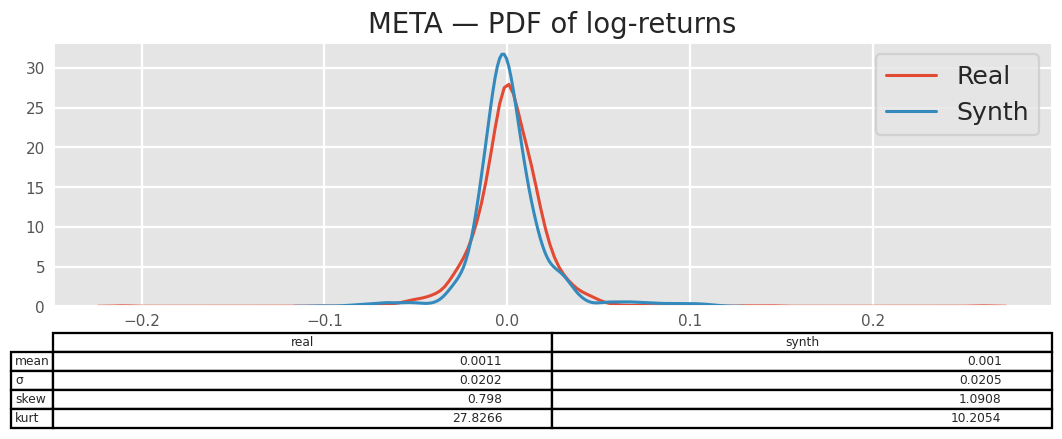


TROW  descriptive stats
         real   synth
mean  0.0003  0.0002
σ     0.0133  0.0168
skew -0.1816  0.3811
kurt  5.3883  3.7165 



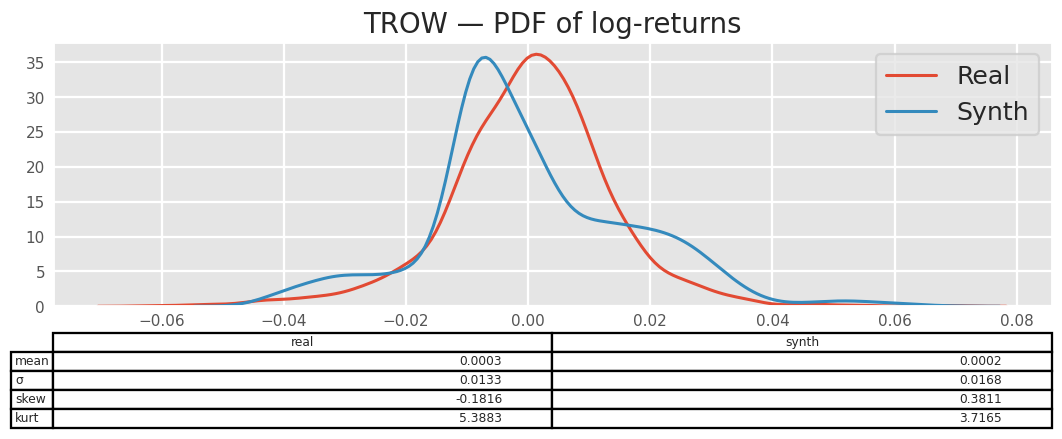

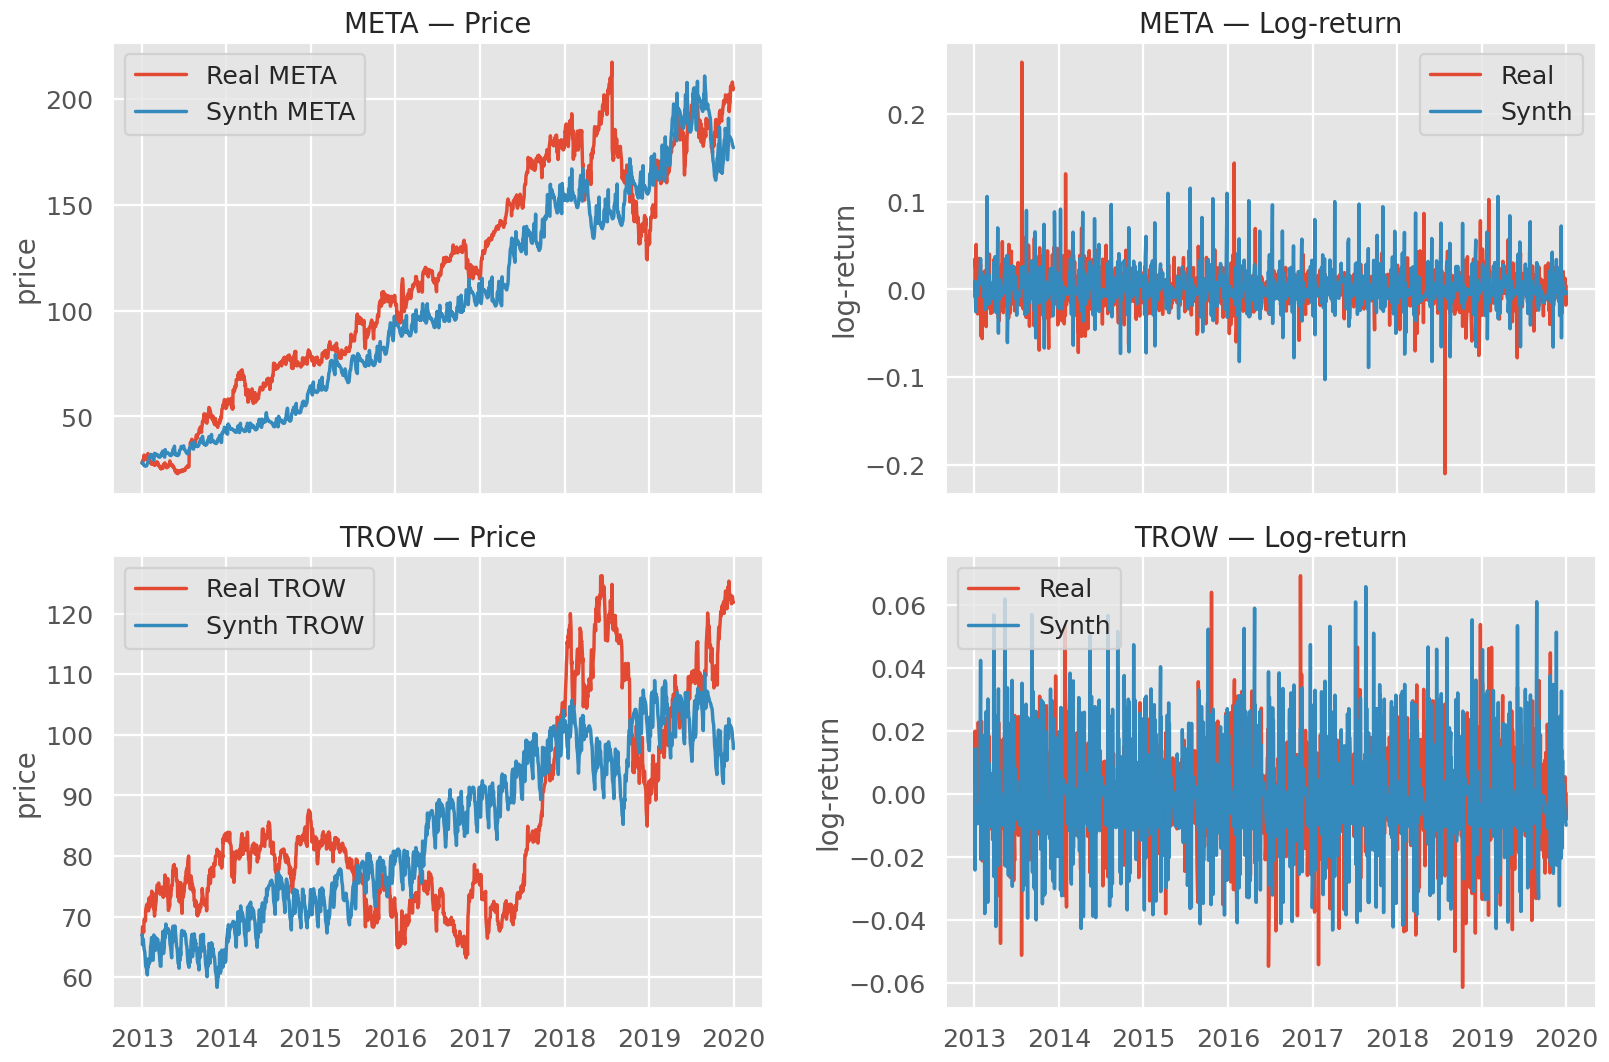

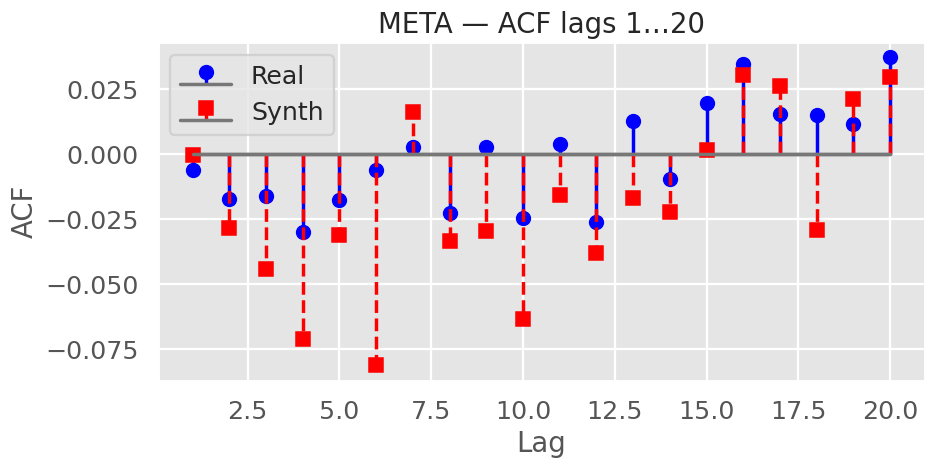

META : Ljung-Box p-value  real=0.863  synth=0.000


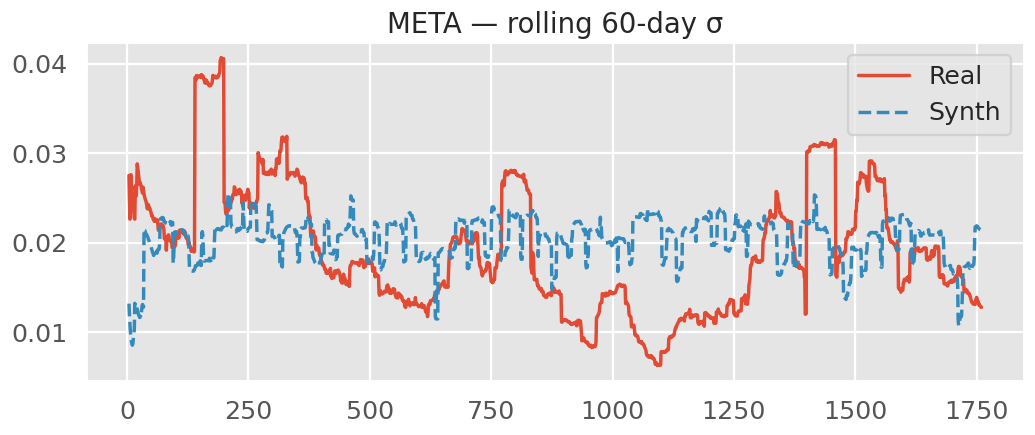

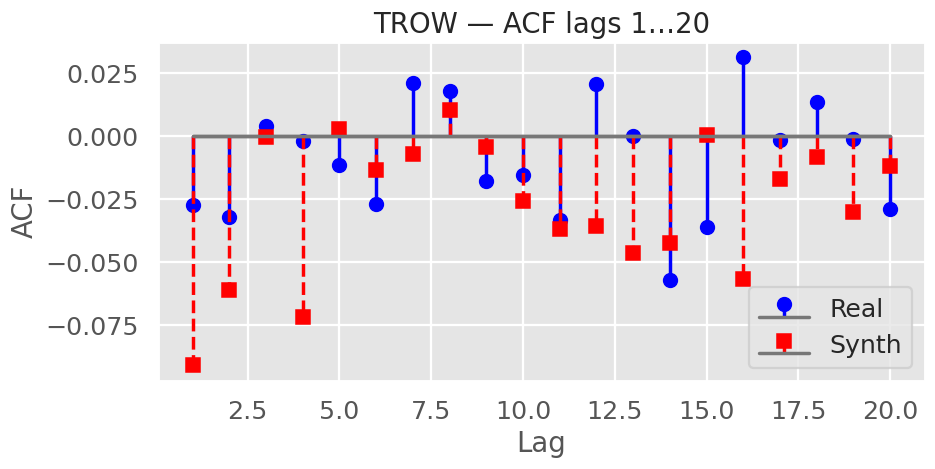

TROW : Ljung-Box p-value  real=0.374  synth=0.000


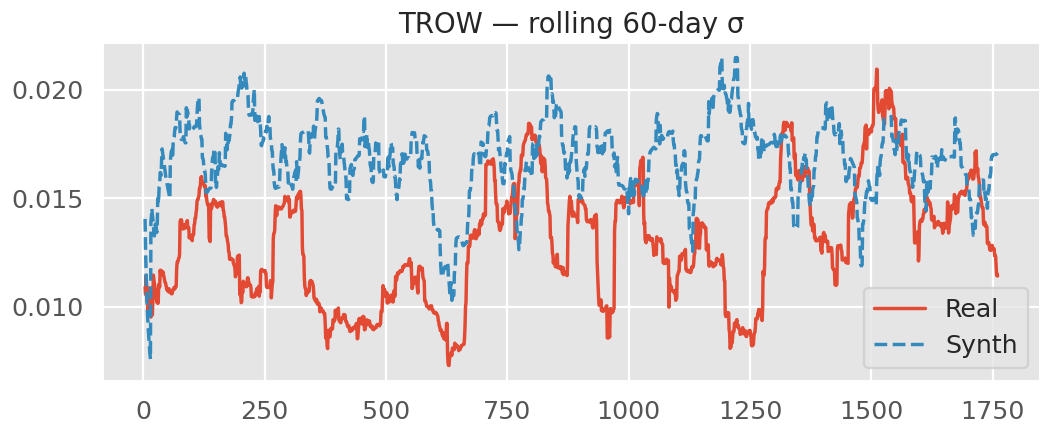


Cross-asset Pearson correlations
Real :
 [[1.   0.33]
 [0.33 1.  ]]
Synth:
 [[ 1.    -0.086]
 [-0.086  1.   ]]
META :  KS-p = 0.000   W-dist = 0.003034
TROW :  KS-p = 0.000   W-dist = 0.003978
META :  VaR₅%  real=-0.02821  synth=-0.02334   ES₅%  real=-0.04371  synth=-0.04113
TROW :  VaR₅%  real=-0.02141  synth=-0.03042   ES₅%  real=-0.03154  synth=-0.03722


In [ ]:
# ------------------------------------------------------------------
# 0.  imports  (add once at the top of the notebook)
# ------------------------------------------------------------------
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from scipy.stats import skew, kurtosis, t as student_t
from sklearn.preprocessing import StandardScaler

plt.style.use("ggplot")
sns.set_context("talk")

# ------------------------------------------------------------------
# 1.  LOAD REAL DATA  &  FIT SCALERS
# ------------------------------------------------------------------
ASSETS      = ["META", "TROW"]        # column order
SEQ_LEN     = 120                     # window length used in training
PRICE_CLIP  = 0.25                 # exp(log-return) safeguard

csv = "meta_msft_2013_2019.csv"       # adjust if needed
df_price = (pd.read_csv(csv, index_col=0, parse_dates=True)
              .sort_index()[ASSETS])

real_prices     = df_price.values
real_logreturns = np.log(df_price).diff().dropna()        # (T-1, F)

scalers = [StandardScaler().fit(real_logreturns[[c]]) for c in ASSETS]

# ------------------------------------------------------------------
# 2.  GENERATE SYNTHETIC LOG-RETURNS  (feature-wise stitching)
# ------------------------------------------------------------------
def t_noise(shape, df=5, scale=0.6):
    sigma = np.sqrt(df/(df-2))
    return scale * student_t.rvs(df, size=shape) / sigma

def synth_logr_full(model, total_len, win, z_dim, scalers):
    """Return DataFrame of stitched synthetic log-returns."""
    F = len(scalers)
    out = np.zeros((total_len-1, F), dtype=np.float32)
    idx = 0
    while idx < total_len-1:
        cur_win = min(win, total_len-1-idx)
        Z = t_noise((1, cur_win, z_dim)).astype(np.float32)

        H = model.supervisor_model(model.generator_model(Z), training=False)
        r = model.recovery_model(H, training=False).numpy()[0]          # (cur_win, F)

        # de-standardise feature-wise
        for f, sc in enumerate(scalers):
            r[:, f] = sc.inverse_transform(r[:, f:f+1]).ravel()

        out[idx:idx+cur_win] = r
        idx += cur_win

    dates = df_price.index[1:]          # align with real returns
    return pd.DataFrame(out, index=dates, columns=ASSETS)

synth_logr_df = synth_logr_full(model, len(df_price), SEQ_LEN,
                                model.z_dim, scalers)

# ------------------------------------------------------------------
# 3.  LOG-RETURNS ➜ PRICES
# ------------------------------------------------------------------
def returns_to_prices(p0, r_df, clip):
    r_clipped = r_df.clip(-clip, clip).to_numpy()
    P = np.empty((r_clipped.shape[0]+1, r_clipped.shape[1]), dtype=np.float32)
    P[0] = p0
    P[1:] = p0 * np.exp(r_clipped.cumsum(axis=0))
    dates = df_price.index          # keep original trading calendar
    return pd.DataFrame(P, index=dates, columns=ASSETS)

synth_price_df = returns_to_prices(real_prices[0], synth_logr_df, PRICE_CLIP)

# ------------------------------------------------------------------
# 4.  PRINT  &  (OPTIONALLY) SAVE  DATA
# ------------------------------------------------------------------
print("Synthetic log-returns (head):\n", synth_logr_df.head(), "\n")
print("Synthetic prices      (tail):\n", synth_price_df.tail(), "\n")

# comment these two lines out if you don't need CSVs
synth_logr_df.to_csv("synthetic_logreturns.csv")
synth_price_df.to_csv("synthetic_prices.csv")

# ------------------------------------------------------------------
# 5.  PLOT  –  PDFs + descriptive stats
# ------------------------------------------------------------------
real_logr_np = real_logreturns.values        # (T-1, F)

for f, asset in enumerate(ASSETS):
    fig, ax = plt.subplots(figsize=(10, 5))

    # PDF curves
    sns.kdeplot(real_logr_np[:, f],   ax=ax, label="Real",  linewidth=2)
    sns.kdeplot(synth_logr_df[asset], ax=ax, label="Synth", linewidth=2)

    # Cosmetics ----------------------------------------------------
    ax.set_title(f"{asset} — PDF of log-returns")
    ax.set_xlabel("")            # ← remove x-axis label
    ax.set_ylabel("")            # ← remove y-axis ("Density")
    ax.tick_params(axis='both', labelsize=10, pad=-4)  # ← smaller tick numbers
    ax.legend(); ax.grid(True)

    # descriptive statistics --------------------------------------
    stats = pd.DataFrame({
        "real":  [real_logr_np[:, f].mean(),
                  real_logr_np[:, f].std(ddof=1),
                  skew(real_logr_np[:, f]),
                  kurtosis(real_logr_np[:, f], fisher=False)],
        "synth": [synth_logr_df[asset].mean(),
                  synth_logr_df[asset].std(ddof=1),
                  skew(synth_logr_df[asset]),
                  kurtosis(synth_logr_df[asset], fisher=False)]
    }, index=["mean", "σ", "skew", "kurt"])

    print(f"\n{asset}  descriptive stats\n", stats.round(4), "\n")

    # table under the plot
    tbl = ax.table(
        cellText  = stats.round(4).values,
        rowLabels = stats.index,
        colLabels = ["real", "synth"],
        loc       = "lower center",
        bbox      = [0, -0.46, 1, 0.36]
    )
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(8)

    plt.tight_layout()
    plt.show()
# ------------------------------------------------------------------
# 6.  PLOT FULL TRAJECTORIES  –  PRICES  &  LOG-RETURNS
# ------------------------------------------------------------------
fig, axs = plt.subplots(len(ASSETS), 2, figsize=(15, 5*len(ASSETS)),
                        sharex='col')

for row, asset in enumerate(ASSETS):
    # ---- prices -------------------------------------------------
    axs[row, 0].plot(df_price[asset],           label=f"Real {asset}")
    axs[row, 0].plot(synth_price_df[asset],     label=f"Synth {asset}")
    axs[row, 0].set_title(f"{asset} — Price")
    axs[row, 0].set_ylabel("price")
    axs[row, 0].legend(); axs[row, 0].grid(True)

    # ---- log-returns -------------------------------------------
    axs[row, 1].plot(real_logreturns[asset],     label="Real")
    axs[row, 1].plot(synth_logr_df[asset],       label="Synth")
    axs[row, 1].set_title(f"{asset} — Log-return")
    axs[row, 1].set_ylabel("log-return")
    axs[row, 1].legend(); axs[row, 1].grid(True)

plt.tight_layout()
plt.show()

# ══════════════════════════════════════════════════════════════
#  7 · DIAGNOSTICS (ACF / Ljung-Box • rolling σ • corr • KS/W • VaR/ES)
# ══════════════════════════════════════════════════════════════
# --- one-off imports ------------------------------------------
from statsmodels.tsa.stattools    import acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats                  import ks_2samp, wasserstein_distance

MAX_LAG  = 20        # for ACF & Ljung-Box
ROLL_WND = 60        # rolling-σ window (in trading days)
TAIL_Q   = 0.05      # 5 % tail for VaR / ES

synthetic_logr = synth_logr_df.values      # convenience NumPy view
real_logr_np   = real_logr_np              # already defined above

for f, asset in enumerate(ASSETS):
    # ── ACF & Ljung-Box ─────────────────────────────────────────
    acf_real = acf(real_logr_np[:, f],  nlags=MAX_LAG, fft=True)
    acf_fake = acf(synthetic_logr[:, f], nlags=MAX_LAG, fft=True)

    plt.figure(figsize=(9, 4))
    plt.stem(range(1, MAX_LAG+1), acf_real[1:], linefmt='b-', markerfmt='bo')
    plt.stem(range(1, MAX_LAG+1), acf_fake[1:], linefmt='r--', markerfmt='rs')
    plt.title(f"{asset} — ACF lags 1…{MAX_LAG}")
    plt.xlabel("Lag"); plt.ylabel("ACF")
    plt.legend(["Real", "Synth"]); plt.grid(True); plt.show()

    p_real = acorr_ljungbox(real_logr_np[:, f],  lags=[MAX_LAG],
                            return_df=True)["lb_pvalue"].iloc[0]
    p_fake = acorr_ljungbox(synthetic_logr[:, f], lags=[MAX_LAG],
                            return_df=True)["lb_pvalue"].iloc[0]
    print(f"{asset:5}: Ljung-Box p-value  real={p_real:.3f}  synth={p_fake:.3f}")

    # ── rolling volatility ─────────────────────────────────────
    σ_real = (pd.Series(real_logr_np[:, f])
                .rolling(ROLL_WND, min_periods=5).std())
    σ_fake = (pd.Series(synthetic_logr[:, f])
                .rolling(ROLL_WND, min_periods=5).std())

    plt.figure(figsize=(11, 4))
    plt.plot(σ_real, label="Real")
    plt.plot(σ_fake, '--', label="Synth")
    plt.title(f"{asset} — rolling {ROLL_WND}-day σ")
    plt.legend(); plt.grid(True); plt.show()

# ── cross-asset Pearson correlation matrix ─────────────────────
print("\nCross-asset Pearson correlations")
print("Real :\n",  np.round(np.corrcoef(real_logr_np.T),  3))
print("Synth:\n", np.round(np.corrcoef(synthetic_logr.T), 3))

# ── KS & Wasserstein tests ─────────────────────────────────────
for f, asset in enumerate(ASSETS):
    ks_p   = ks_2samp(real_logr_np[:, f], synthetic_logr[:, f]).pvalue
    w_dist = wasserstein_distance(real_logr_np[:, f], synthetic_logr[:, f])
    print(f"{asset:5}:  KS-p = {ks_p:.3f}   W-dist = {w_dist:.4g}")

# ── VaR & ES on the left 5 % tail ──────────────────────────────
for f, asset in enumerate(ASSETS):
    r_r, r_f = real_logr_np[:, f], synthetic_logr[:, f]
    var_r, var_f = np.quantile(r_r, TAIL_Q), np.quantile(r_f, TAIL_Q)
    es_r = r_r[r_r <= var_r].mean()
    es_f = r_f[r_f <= var_f].mean()
    print(f"{asset:5}:  VaR₅%  real={var_r:+.5f}  synth={var_f:+.5f}   "
          f"ES₅%  real={es_r:+.5f}  synth={es_f:+.5f}")


#STYLIZED FACTS ANALYSIS

In [ ]:
# ────────────────────────────────────────────────────────────────
# Comprehensive Stylised-fact dashboard for financial data
# ----------------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.tsa.stattools import acf
from scipy.stats import kurtosis, jarque_bera, norm, kstest, pearsonr
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

def run_comprehensive_stylized_tests(r, asset_name, lags=20):
    """
    Run comprehensive stylized fact tests for financial time series

    Args:
        r: pandas Series of returns
        asset_name: string name of the asset
        lags: number of lags for autocorrelation tests

    Returns:
        dict: Dictionary containing all test results
    """
    results = {'Asset': asset_name}

    # Clean data
    r_clean = r.dropna()

    # ═══════════════════════════════════════════════════════════════
    # 1. LINEAR UNPREDICTABILITY TESTS
    # ═══════════════════════════════════════════════════════════════

    # Autocorrelation Function
    acf_values = acf(r_clean, nlags=lags, fft=True)
    results['ACF_Lag1'] = acf_values[1]
    results['ACF_Lag5'] = acf_values[5] if len(acf_values) > 5 else np.nan
    results['ACF_Mean_1_10'] = np.mean(np.abs(acf_values[1:11]))

    # Ljung-Box Test for serial correlation
    lb_result = acorr_ljungbox(r_clean, lags=[10, 20], return_df=True)
    results['LjungBox_10_pval'] = lb_result["lb_pvalue"].iloc[0]
    results['LjungBox_20_pval'] = lb_result["lb_pvalue"].iloc[1] if len(lb_result) > 1 else np.nan

    # ═══════════════════════════════════════════════════════════════
    # 2. VOLATILITY CLUSTERING TESTS
    # ═══════════════════════════════════════════════════════════════

    # Autocorrelation of absolute returns
    abs_returns = np.abs(r_clean)
    abs_acf = acf(abs_returns, nlags=lags, fft=True)
    results['ACF_AbsRet_Lag1'] = abs_acf[1]
    results['ACF_AbsRet_Lag5'] = abs_acf[5] if len(abs_acf) > 5 else np.nan
    results['ACF_AbsRet_Mean_1_10'] = np.mean(abs_acf[1:11])

    # Autocorrelation of squared returns
    sq_returns = np.square(r_clean)
    sq_acf = acf(sq_returns, nlags=lags, fft=True)
    results['ACF_SqRet_Lag1'] = sq_acf[1]
    results['ACF_SqRet_Lag5'] = sq_acf[5] if len(sq_acf) > 5 else np.nan
    results['ACF_SqRet_Mean_1_10'] = np.mean(sq_acf[1:11])

    # ARCH-LM Test for conditional heteroscedasticity
    try:
        arch_result = het_arch(r_clean, nlags=5)
        results['ARCH_LM_pval'] = arch_result[1]
        results['ARCH_LM_stat'] = arch_result[0]
    except:
        results['ARCH_LM_pval'] = np.nan
        results['ARCH_LM_stat'] = np.nan

    # ═══════════════════════════════════════════════════════════════
    # 3. FAT TAILS / NON-NORMALITY TESTS
    # ═══════════════════════════════════════════════════════════════

    # Excess Kurtosis
    results['Excess_Kurtosis'] = kurtosis(r_clean, fisher=True)

    # Jarque-Bera Test for normality
    jb_stat, jb_pval = jarque_bera(r_clean)
    results['JarqueBera_stat'] = jb_stat
    results['JarqueBera_pval'] = jb_pval

    # Kolmogorov-Smirnov Test for normality
    standardized = (r_clean - r_clean.mean()) / r_clean.std(ddof=1)
    ks_stat, ks_pval = kstest(standardized, norm.cdf)
    results['KS_Normal_stat'] = ks_stat
    results['KS_Normal_pval'] = ks_pval

    # ═══════════════════════════════════════════════════════════════
    # 4. GAIN/LOSS ASYMMETRY TESTS
    # ═══════════════════════════════════════════════════════════════

    positive_returns = r_clean[r_clean > 0]
    negative_returns = r_clean[r_clean < 0]

    results['Mean_Gain'] = positive_returns.mean() if len(positive_returns) > 0 else np.nan
    results['Mean_Loss'] = -negative_returns.mean() if len(negative_returns) > 0 else np.nan
    results['Gain_Loss_Ratio'] = (positive_returns.mean() / (-negative_returns.mean())) if len(positive_returns) > 0 and len(negative_returns) > 0 else np.nan

    # Skewness (asymmetry measure)
    results['Skewness'] = r_clean.skew()

    # Count asymmetry
    results['Pct_Positive'] = (r_clean > 0).mean() * 100
    results['Pct_Negative'] = (r_clean < 0).mean() * 100

    # ═══════════════════════════════════════════════════════════════
    # 5. LEVERAGE EFFECT TESTS
    # ═══════════════════════════════════════════════════════════════

    # Correlation between returns and future volatility
    if len(r_clean) > 1:
        future_vol = np.abs(r_clean.shift(-1))
        results['Leverage_Corr_AbsRet'] = r_clean.corr(future_vol)

        # Correlation with squared future returns
        future_sq = np.square(r_clean.shift(-1))
        results['Leverage_Corr_SqRet'] = r_clean.corr(future_sq)

        # Asymmetric correlation (negative vs positive returns)
        neg_mask = r_clean < 0
        pos_mask = r_clean > 0

        if neg_mask.sum() > 1 and pos_mask.sum() > 1:
            neg_corr = r_clean[neg_mask].corr(future_vol[neg_mask])
            pos_corr = r_clean[pos_mask].corr(future_vol[pos_mask])
            results['Leverage_Neg_Corr'] = neg_corr
            results['Leverage_Pos_Corr'] = pos_corr
            results['Leverage_Asymmetry'] = neg_corr - pos_corr
        else:
            results['Leverage_Neg_Corr'] = np.nan
            results['Leverage_Pos_Corr'] = np.nan
            results['Leverage_Asymmetry'] = np.nan
    else:
        results['Leverage_Corr_AbsRet'] = np.nan
        results['Leverage_Corr_SqRet'] = np.nan
        results['Leverage_Neg_Corr'] = np.nan
        results['Leverage_Pos_Corr'] = np.nan
        results['Leverage_Asymmetry'] = np.nan

    # ═══════════════════════════════════════════════════════════════
    # 6. ADDITIONAL DESCRIPTIVE STATISTICS
    # ═══════════════════════════════════════════════════════════════

    results['Mean_Return'] = r_clean.mean()
    results['Std_Return'] = r_clean.std()
    results['Min_Return'] = r_clean.min()
    results['Max_Return'] = r_clean.max()
    results['N_Observations'] = len(r_clean)

    return results

def create_summary_table(results_list):
    """
    Create formatted summary tables for different categories of tests
    """
    df = pd.DataFrame(results_list)
    df = df.set_index('Asset')

    # Table 1: Linear Unpredictability
    unpred_cols = ['ACF_Lag1', 'ACF_Lag5', 'ACF_Mean_1_10', 'LjungBox_10_pval', 'LjungBox_20_pval']
    unpred_table = df[unpred_cols].copy()
    unpred_table.columns = ['ACF Lag 1', 'ACF Lag 5', 'Mean |ACF| 1-10', 'LB Test p (10)', 'LB Test p (20)']

    # Table 2: Volatility Clustering
    vol_cols = ['ACF_AbsRet_Lag1', 'ACF_AbsRet_Mean_1_10', 'ACF_SqRet_Lag1', 'ACF_SqRet_Mean_1_10', 'ARCH_LM_pval']
    vol_table = df[vol_cols].copy()
    vol_table.columns = ['ACF |r| Lag 1', 'Mean ACF |r| 1-10', 'ACF r² Lag 1', 'Mean ACF r² 1-10', 'ARCH-LM p']

    # Table 3: Fat Tails
    fat_cols = ['Excess_Kurtosis', 'JarqueBera_pval', 'KS_Normal_pval', 'Skewness']
    fat_table = df[fat_cols].copy()
    fat_table.columns = ['Excess Kurtosis', 'Jarque-Bera p', 'KS Normal p', 'Skewness']

    # Table 4: Gain/Loss Asymmetry
    asym_cols = ['Mean_Gain', 'Mean_Loss', 'Gain_Loss_Ratio', 'Pct_Positive', 'Pct_Negative']
    asym_table = df[asym_cols].copy()
    asym_table.columns = ['Mean Gain', 'Mean Loss', 'Gain/Loss Ratio', '% Positive', '% Negative']

    # Table 5: Leverage Effect
    lev_cols = ['Leverage_Corr_AbsRet', 'Leverage_Corr_SqRet', 'Leverage_Neg_Corr', 'Leverage_Pos_Corr', 'Leverage_Asymmetry']
    lev_table = df[lev_cols].copy()
    lev_table.columns = ['Corr(r,|r+1|)', 'Corr(r,r²+1)', 'Neg Corr', 'Pos Corr', 'Asymmetry']

    return unpred_table, vol_table, fat_table, asym_table, lev_table, df

def print_stylized_facts_analysis(file_path):
    """
    Complete stylized facts analysis with formatted output
    """
    print("═" * 80)
    print("COMPREHENSIVE STYLIZED FACTS ANALYSIS")
    print("═" * 80)

    # Load data
    try:
        df_ret = pd.read_excel(file_path, sheet_name=0, index_col=0, parse_dates=True)
        print(f"✓ Successfully loaded data from {file_path}")
        print(f"  Data shape: {df_ret.shape}")
        print(f"  Columns: {list(df_ret.columns)}")
        print(f"  Date range: {df_ret.index.min()} to {df_ret.index.max()}")
    except FileNotFoundError:
        print(f"✗ File not found: {file_path}")
        print("Creating dummy data for demonstration...")

        # Create dummy data
        np.random.seed(42)
        dates = pd.date_range(start='2013-01-01', end='2020-01-01', freq='B')
        n = len(dates)

        # Simulate more realistic financial returns with stylized facts
        meta_returns = np.random.normal(0, 0.01, n) + 0.1 * np.random.normal(0, 0.01, n)**3
        trow_returns = np.random.normal(0, 0.008, n) + 0.08 * np.random.normal(0, 0.008, n)**3

        df_ret = pd.DataFrame({'META': meta_returns, 'TROW': trow_returns}, index=dates)

    print("\n" + "─" * 80)

    # Run tests for each asset
    results_list = []
    for col in df_ret.columns:
        print(f"\n🔍 Analyzing {col}...")
        results = run_comprehensive_stylized_tests(df_ret[col].dropna(), col)
        results_list.append(results)

    # Create summary tables
    unpred_table, vol_table, fat_table, asym_table, lev_table, full_df = create_summary_table(results_list)

    # Print formatted tables
    print("\n" + "═" * 80)
    print("1. LINEAR UNPREDICTABILITY TESTS")
    print("═" * 80)
    print("Interpretation: Low ACF values and high p-values indicate unpredictability")
    print(tabulate(unpred_table, headers='keys', tablefmt='grid', floatfmt='.6f'))

    print("\n" + "═" * 80)
    print("2. VOLATILITY CLUSTERING TESTS")
    print("═" * 80)
    print("Interpretation: High ACF in |r| and r², low ARCH-LM p-value indicate clustering")
    print(tabulate(vol_table, headers='keys', tablefmt='grid', floatfmt='.6f'))

    print("\n" + "═" * 80)
    print("3. FAT TAILS / NON-NORMALITY TESTS")
    print("═" * 80)
    print("Interpretation: High kurtosis, low JB/KS p-values indicate fat tails")
    print(tabulate(fat_table, headers='keys', tablefmt='grid', floatfmt='.6f'))

    print("\n" + "═" * 80)
    print("4. GAIN/LOSS ASYMMETRY TESTS")
    print("═" * 80)
    print("Interpretation: Unequal gains/losses, negative skewness indicate asymmetry")
    print(tabulate(asym_table, headers='keys', tablefmt='grid', floatfmt='.6f'))

    print("\n" + "═" * 80)
    print("5. LEVERAGE EFFECT TESTS")
    print("═" * 80)
    print("Interpretation: Negative correlations, especially for negative returns, indicate leverage effect")
    print(tabulate(lev_table, headers='keys', tablefmt='grid', floatfmt='.6f'))

    # Summary interpretation
    print("\n" + "═" * 80)
    print("SUMMARY INTERPRETATION")
    print("═" * 80)

    for asset in full_df.index:
        print(f"\n📊 {asset} Analysis:")

        # Linear unpredictability
        lb_p = full_df.loc[asset, 'LjungBox_20_pval']
        if lb_p > 0.05:
            print(f"  ✓ Linear unpredictability: CONFIRMED (LB p-value: {lb_p:.3f})")
        else:
            print(f"  ✗ Linear unpredictability: REJECTED (LB p-value: {lb_p:.3f})")

        # Volatility clustering
        arch_p = full_df.loc[asset, 'ARCH_LM_pval']
        abs_acf = full_df.loc[asset, 'ACF_AbsRet_Mean_1_10']
        if not pd.isna(arch_p) and arch_p < 0.05 and abs_acf > 0.05:
            print(f"  ✓ Volatility clustering: CONFIRMED (ARCH p: {arch_p:.3f}, ACF |r|: {abs_acf:.3f})")
        else:
            print(f"  ✗ Volatility clustering: WEAK/ABSENT (ARCH p: {arch_p:.3f}, ACF |r|: {abs_acf:.3f})")

        # Fat tails
        excess_kurt = full_df.loc[asset, 'Excess_Kurtosis']
        jb_p = full_df.loc[asset, 'JarqueBera_pval']
        if excess_kurt > 0 and jb_p < 0.05:
            print(f"  ✓ Fat tails: CONFIRMED (Excess kurtosis: {excess_kurt:.3f}, JB p: {jb_p:.3f})")
        else:
            print(f"  ✗ Fat tails: WEAK/ABSENT (Excess kurtosis: {excess_kurt:.3f}, JB p: {jb_p:.3f})")

        # Gain/loss asymmetry
        skewness = full_df.loc[asset, 'Skewness']
        gain_loss_ratio = full_df.loc[asset, 'Gain_Loss_Ratio']
        if abs(skewness) > 0.1 or abs(gain_loss_ratio - 1) > 0.1:
            print(f"  ✓ Gain/loss asymmetry: CONFIRMED (Skewness: {skewness:.3f}, G/L ratio: {gain_loss_ratio:.3f})")
        else:
            print(f"  ✗ Gain/loss asymmetry: WEAK (Skewness: {skewness:.3f}, G/L ratio: {gain_loss_ratio:.3f})")

        # Leverage effect
        lev_corr = full_df.loc[asset, 'Leverage_Corr_AbsRet']
        lev_asym = full_df.loc[asset, 'Leverage_Asymmetry']
        if not pd.isna(lev_corr) and lev_corr < -0.05:
            print(f"  ✓ Leverage effect: CONFIRMED (Corr: {lev_corr:.3f}, Asymmetry: {lev_asym:.3f})")
        else:
            print(f"  ✗ Leverage effect: WEAK/ABSENT (Corr: {lev_corr:.3f}, Asymmetry: {lev_asym:.3f})")

    return full_df

# ═══════════════════════════════════════════════════════════════
# RUN THE ANALYSIS
# ═══════════════════════════════════════════════════════════════

if __name__ == "__main__":
    # Adjust the file path as needed
    file_path = "/content/synthetic_data_BOTH.xlsx"  # Change this to your file path

    # Run the complete analysis
    results_df = print_stylized_facts_analysis(file_path)

    # Optionally save results to CSV
    results_df.to_csv('stylized_facts_results.csv')
    print(f"\n💾 Results saved to 'stylized_facts_results.csv'")


════════════════════════════════════════════════════════════════════════════════
COMPREHENSIVE STYLIZED FACTS ANALYSIS
════════════════════════════════════════════════════════════════════════════════
✓ Successfully loaded data from /content/synthetic_data_BOTH.xlsx
  Data shape: (1761, 2)
  Columns: ['META', 'TROW']
  Date range: 2013-01-03 00:00:00 to 2019-12-31 00:00:00

────────────────────────────────────────────────────────────────────────────────

🔍 Analyzing META...

🔍 Analyzing TROW...

════════════════════════════════════════════════════════════════════════════════
1. LINEAR UNPREDICTABILITY TESTS
════════════════════════════════════════════════════════════════════════════════
Interpretation: Low ACF values and high p-values indicate unpredictability
+---------+-------------+-------------+-------------------+------------------+------------------+
| Asset   |   ACF Lag 1 |   ACF Lag 5 |   Mean |ACF| 1-10 |   LB Test p (10) |   LB Test p (20) |
+=========+=============+=========

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.tsa.stattools import acf
from scipy.stats import kurtosis, jarque_bera, norm, kstest
from tabulate import tabulate
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

def load_and_preprocess_real_data(file_path, start_date='2013-01-01', end_date='2020-01-01'):
    """
    Load and preprocess real SP500 data for META and TROW

    Args:
        file_path: Path to SP500_data_fixed.xlsx
        start_date: Start date for filtering
        end_date: End date for filtering

    Returns:
        real_log_returns: DataFrame with log returns for META and TROW
        real_prices: DataFrame with price data
    """

    print("Loading SP500 data...")
    try:
        # Load the Excel file
        real_df = pd.read_excel(file_path)
        print(f"✓ Successfully loaded data with shape: {real_df.shape}")
        print(f"✓ Columns available: {list(real_df.columns)}")

    except FileNotFoundError:
        print(f"✗ File not found: {file_path}")
        print("Please ensure the file exists in the specified path.")
        return None, None
    except Exception as e:
        print(f"✗ Error loading file: {e}")
        return None, None

    # Convert date column to datetime if not already
    date_col = None
    for col in real_df.columns:
        if 'date' in col.lower() or 'time' in col.lower():
            date_col = col
            break

    if date_col is None:
        print("✗ No date column found. Please ensure your file has a date column.")
        return None, None

    if not pd.api.types.is_datetime64_any_dtype(real_df[date_col]):
        real_df[date_col] = pd.to_datetime(real_df[date_col])
        print(f"✓ Converted {date_col} to datetime")

    # Filter date range
    start_dt = pd.to_datetime(start_date)
    end_dt = pd.to_datetime(end_date)

    mask = (real_df[date_col] >= start_dt) & (real_df[date_col] < end_dt)
    real_filtered = real_df.loc[mask].copy()

    print(f"✓ Filtered data from {start_date} to {end_date}")
    print(f"✓ Filtered data shape: {real_filtered.shape}")
    print(f"✓ Date range: {real_filtered[date_col].min()} to {real_filtered[date_col].max()}")

    # Find META and TROW columns
    meta_cols = [col for col in real_filtered.columns if 'META' in col.upper()]
    trow_cols = [col for col in real_filtered.columns if 'TROW' in col.upper()]

    print(f"✓ Found META columns: {meta_cols}")
    print(f"✓ Found TROW columns: {trow_cols}")

    if not meta_cols:
        print("✗ No META column found. Available columns:")
        print([col for col in real_filtered.columns if col != date_col])
        return None, None

    if not trow_cols:
        print("✗ No TROW column found. Available columns:")
        print([col for col in real_filtered.columns if col != date_col])
        return None, None

    # Use the first found column for each stock
    meta_col = meta_cols[0]
    trow_col = trow_cols[0]

    # Extract prices for META and TROW
    real_prices = real_filtered[[date_col, meta_col, trow_col]].copy()
    real_prices = real_prices.dropna()
    real_prices.set_index(date_col, inplace=True)

    # Rename columns for consistency
    real_prices.columns = ['META', 'TROW']

    print(f"✓ Extracted price data shape: {real_prices.shape}")
    print(f"✓ Price data date range: {real_prices.index.min()} to {real_prices.index.max()}")

    # Calculate log returns
    real_log_returns = np.log(real_prices / real_prices.shift(1)).dropna()

    print(f"✓ Calculated log returns shape: {real_log_returns.shape}")
    print(f"✓ Log returns summary:")
    print(real_log_returns.describe())

    return real_log_returns, real_prices

def run_comprehensive_stylized_tests(r, asset_name, lags=20):
    """
    Run comprehensive stylized fact tests for financial time series
    """
    results = {'Asset': asset_name}
    r_clean = r.dropna()

    # 1. LINEAR UNPREDICTABILITY TESTS
    acf_values = acf(r_clean, nlags=lags, fft=True)
    results['ACF_Lag1'] = acf_values[1]
    results['ACF_Lag5'] = acf_values[5] if len(acf_values) > 5 else np.nan
    results['ACF_Mean_1_10'] = np.mean(np.abs(acf_values[1:11]))

    lb_result = acorr_ljungbox(r_clean, lags=[10, 20], return_df=True)
    results['LjungBox_10_pval'] = lb_result["lb_pvalue"].iloc[0]
    results['LjungBox_20_pval'] = lb_result["lb_pvalue"].iloc[1] if len(lb_result) > 1 else np.nan

    # 2. VOLATILITY CLUSTERING TESTS
    abs_returns = np.abs(r_clean)
    abs_acf = acf(abs_returns, nlags=lags, fft=True)
    results['ACF_AbsRet_Lag1'] = abs_acf[1]
    results['ACF_AbsRet_Lag5'] = abs_acf[5] if len(abs_acf) > 5 else np.nan
    results['ACF_AbsRet_Mean_1_10'] = np.mean(abs_acf[1:11])

    sq_returns = np.square(r_clean)
    sq_acf = acf(sq_returns, nlags=lags, fft=True)
    results['ACF_SqRet_Lag1'] = sq_acf[1]
    results['ACF_SqRet_Lag5'] = sq_acf[5] if len(sq_acf) > 5 else np.nan
    results['ACF_SqRet_Mean_1_10'] = np.mean(sq_acf[1:11])

    try:
        arch_result = het_arch(r_clean, nlags=5)
        results['ARCH_LM_pval'] = arch_result[1]
        results['ARCH_LM_stat'] = arch_result[0]
    except:
        results['ARCH_LM_pval'] = np.nan
        results['ARCH_LM_stat'] = np.nan

    # 3. FAT TAILS / NON-NORMALITY TESTS
    results['Excess_Kurtosis'] = kurtosis(r_clean, fisher=True)

    jb_stat, jb_pval = jarque_bera(r_clean)
    results['JarqueBera_stat'] = jb_stat
    results['JarqueBera_pval'] = jb_pval

    standardized = (r_clean - r_clean.mean()) / r_clean.std(ddof=1)
    ks_stat, ks_pval = kstest(standardized, norm.cdf)
    results['KS_Normal_stat'] = ks_stat
    results['KS_Normal_pval'] = ks_pval

    # 4. GAIN/LOSS ASYMMETRY TESTS
    positive_returns = r_clean[r_clean > 0]
    negative_returns = r_clean[r_clean < 0]

    results['Mean_Gain'] = positive_returns.mean() if len(positive_returns) > 0 else np.nan
    results['Mean_Loss'] = -negative_returns.mean() if len(negative_returns) > 0 else np.nan
    results['Gain_Loss_Ratio'] = (positive_returns.mean() / (-negative_returns.mean())) if len(positive_returns) > 0 and len(negative_returns) > 0 else np.nan

    results['Skewness'] = r_clean.skew()
    results['Pct_Positive'] = (r_clean > 0).mean() * 100
    results['Pct_Negative'] = (r_clean < 0).mean() * 100

    # 5. LEVERAGE EFFECT TESTS
    if len(r_clean) > 1:
        future_vol = np.abs(r_clean.shift(-1))
        results['Leverage_Corr_AbsRet'] = r_clean.corr(future_vol)

        future_sq = np.square(r_clean.shift(-1))
        results['Leverage_Corr_SqRet'] = r_clean.corr(future_sq)

        neg_mask = r_clean < 0
        pos_mask = r_clean > 0

        if neg_mask.sum() > 1 and pos_mask.sum() > 1:
            neg_corr = r_clean[neg_mask].corr(future_vol[neg_mask])
            pos_corr = r_clean[pos_mask].corr(future_vol[pos_mask])
            results['Leverage_Neg_Corr'] = neg_corr
            results['Leverage_Pos_Corr'] = pos_corr
            results['Leverage_Asymmetry'] = neg_corr - pos_corr
        else:
            results['Leverage_Neg_Corr'] = np.nan
            results['Leverage_Pos_Corr'] = np.nan
            results['Leverage_Asymmetry'] = np.nan
    else:
        results['Leverage_Corr_AbsRet'] = np.nan
        results['Leverage_Corr_SqRet'] = np.nan
        results['Leverage_Neg_Corr'] = np.nan
        results['Leverage_Pos_Corr'] = np.nan
        results['Leverage_Asymmetry'] = np.nan

    # 6. ADDITIONAL DESCRIPTIVE STATISTICS
    results['Mean_Return'] = r_clean.mean()
    results['Std_Return'] = r_clean.std()
    results['Min_Return'] = r_clean.min()
    results['Max_Return'] = r_clean.max()
    results['N_Observations'] = len(r_clean)

    return results

def create_summary_tables(results_df):
    """
    Create formatted summary tables for different categories of tests
    """
    # Table 1: Linear Unpredictability
    unpred_cols = ['ACF_Lag1', 'ACF_Lag5', 'ACF_Mean_1_10', 'LjungBox_10_pval', 'LjungBox_20_pval']
    unpred_table = results_df[unpred_cols].copy()
    unpred_table.columns = ['ACF Lag 1', 'ACF Lag 5', 'Mean |ACF| 1-10', 'LB Test p (10)', 'LB Test p (20)']

    # Table 2: Volatility Clustering
    vol_cols = ['ACF_AbsRet_Lag1', 'ACF_AbsRet_Mean_1_10', 'ACF_SqRet_Lag1', 'ACF_SqRet_Mean_1_10', 'ARCH_LM_pval']
    vol_table = results_df[vol_cols].copy()
    vol_table.columns = ['ACF |r| Lag 1', 'Mean ACF |r| 1-10', 'ACF r² Lag 1', 'Mean ACF r² 1-10', 'ARCH-LM p']

    # Table 3: Fat Tails
    fat_cols = ['Excess_Kurtosis', 'JarqueBera_pval', 'KS_Normal_pval', 'Skewness']
    fat_table = results_df[fat_cols].copy()
    fat_table.columns = ['Excess Kurtosis', 'Jarque-Bera p', 'KS Normal p', 'Skewness']

    # Table 4: Gain/Loss Asymmetry
    asym_cols = ['Mean_Gain', 'Mean_Loss', 'Gain_Loss_Ratio', 'Pct_Positive', 'Pct_Negative']
    asym_table = results_df[asym_cols].copy()
    asym_table.columns = ['Mean Gain', 'Mean Loss', 'Gain/Loss Ratio', '% Positive', '% Negative']

    # Table 5: Leverage Effect
    lev_cols = ['Leverage_Corr_AbsRet', 'Leverage_Corr_SqRet', 'Leverage_Neg_Corr', 'Leverage_Pos_Corr', 'Leverage_Asymmetry']
    lev_table = results_df[lev_cols].copy()
    lev_table.columns = ['Corr(r,|r+1|)', 'Corr(r,r²+1)', 'Neg Corr', 'Pos Corr', 'Asymmetry']

    return unpred_table, vol_table, fat_table, asym_table, lev_table

def analyze_real_sp500_data(file_path):
    """
    Complete analysis of real SP500 data
    """
    print("═" * 80)
    print("REAL SP500 DATA STYLIZED FACTS ANALYSIS")
    print("═" * 80)

    # Load and preprocess data
    real_log_returns, real_prices = load_and_preprocess_real_data(file_path)

    if real_log_returns is None:
        print("✗ Failed to load data. Please check your file path and format.")
        return None

    # Run stylized fact tests
    print("\n" + "─" * 80)
    print("RUNNING STYLIZED FACT TESTS")
    print("─" * 80)

    results_list = []
    for col in real_log_returns.columns:
        print(f"\n🔍 Analyzing {col}...")
        results = run_comprehensive_stylized_tests(real_log_returns[col], col)
        results_list.append(results)

    # Create results DataFrame
    results_df = pd.DataFrame(results_list).set_index('Asset')

    # Create summary tables
    unpred_table, vol_table, fat_table, asym_table, lev_table = create_summary_tables(results_df)

    # Print formatted tables
    print("\n" + "═" * 80)
    print("1. LINEAR UNPREDICTABILITY TESTS")
    print("═" * 80)
    print("Interpretation: Low ACF values and high p-values indicate unpredictability")
    print(tabulate(unpred_table, headers='keys', tablefmt='grid', floatfmt='.6f'))

    print("\n" + "═" * 80)
    print("2. VOLATILITY CLUSTERING TESTS")
    print("═" * 80)
    print("Interpretation: High ACF in |r| and r², low ARCH-LM p-value indicate clustering")
    print(tabulate(vol_table, headers='keys', tablefmt='grid', floatfmt='.6f'))

    print("\n" + "═" * 80)
    print("3. FAT TAILS / NON-NORMALITY TESTS")
    print("═" * 80)
    print("Interpretation: High kurtosis, low JB/KS p-values indicate fat tails")
    print(tabulate(fat_table, headers='keys', tablefmt='grid', floatfmt='.6f'))

    print("\n" + "═" * 80)
    print("4. GAIN/LOSS ASYMMETRY TESTS")
    print("═" * 80)
    print("Interpretation: Unequal gains/losses, negative skewness indicate asymmetry")
    print(tabulate(asym_table, headers='keys', tablefmt='grid', floatfmt='.6f'))

    print("\n" + "═" * 80)
    print("5. LEVERAGE EFFECT TESTS")
    print("═" * 80)
    print("Interpretation: Negative correlations, especially for negative returns, indicate leverage effect")
    print(tabulate(lev_table, headers='keys', tablefmt='grid', floatfmt='.6f'))

    # Summary interpretation
    print("\n" + "═" * 80)
    print("SUMMARY INTERPRETATION")
    print("═" * 80)

    for asset in results_df.index:
        print(f"\n📊 {asset} Analysis:")

        # Linear unpredictability
        lb_p = results_df.loc[asset, 'LjungBox_20_pval']
        if lb_p > 0.05:
            print(f"  ✓ Linear unpredictability: CONFIRMED (LB p-value: {lb_p:.3f})")
        else:
            print(f"  ✗ Linear unpredictability: REJECTED (LB p-value: {lb_p:.3f})")

        # Volatility clustering
        arch_p = results_df.loc[asset, 'ARCH_LM_pval']
        abs_acf = results_df.loc[asset, 'ACF_AbsRet_Mean_1_10']
        if not pd.isna(arch_p) and arch_p < 0.05 and abs_acf > 0.05:
            print(f"  ✓ Volatility clustering: CONFIRMED (ARCH p: {arch_p:.3f}, ACF |r|: {abs_acf:.3f})")
        else:
            print(f"  ✗ Volatility clustering: WEAK/ABSENT (ARCH p: {arch_p:.3f}, ACF |r|: {abs_acf:.3f})")

        # Fat tails
        excess_kurt = results_df.loc[asset, 'Excess_Kurtosis']
        jb_p = results_df.loc[asset, 'JarqueBera_pval']
        if excess_kurt > 0 and jb_p < 0.05:
            print(f"  ✓ Fat tails: CONFIRMED (Excess kurtosis: {excess_kurt:.3f}, JB p: {jb_p:.3f})")
        else:
            print(f"  ✗ Fat tails: WEAK/ABSENT (Excess kurtosis: {excess_kurt:.3f}, JB p: {jb_p:.3f})")

        # Gain/loss asymmetry
        skewness = results_df.loc[asset, 'Skewness']
        gain_loss_ratio = results_df.loc[asset, 'Gain_Loss_Ratio']
        if abs(skewness) > 0.1 or abs(gain_loss_ratio - 1) > 0.1:
            print(f"  ✓ Gain/loss asymmetry: CONFIRMED (Skewness: {skewness:.3f}, G/L ratio: {gain_loss_ratio:.3f})")
        else:
            print(f"  ✗ Gain/loss asymmetry: WEAK (Skewness: {skewness:.3f}, G/L ratio: {gain_loss_ratio:.3f})")

        # Leverage effect
        lev_corr = results_df.loc[asset, 'Leverage_Corr_AbsRet']
        lev_asym = results_df.loc[asset, 'Leverage_Asymmetry']
        if not pd.isna(lev_corr) and lev_corr < -0.05:
            print(f"  ✓ Leverage effect: CONFIRMED (Corr: {lev_corr:.3f}, Asymmetry: {lev_asym:.3f})")
        else:
            print(f"  ✗ Leverage effect: WEAK/ABSENT (Corr: {lev_corr:.3f}, Asymmetry: {lev_asym:.3f})")

    # Save results
    results_df.to_csv('real_sp500_stylized_facts_results.csv')
    print(f"\n💾 Results saved to 'real_sp500_stylized_facts_results.csv'")

    return results_df, real_log_returns, real_prices

# ═══════════════════════════════════════════════════════════════
# RUN THE ANALYSIS
# ═══════════════════════════════════════════════════════════════

if __name__ == "__main__":
    # Specify your file path
    file_path = "SP500_data_fixed.xlsx"  # Update this path as needed

    # Run the complete analysis
    try:
        results_df, log_returns, prices = analyze_real_sp500_data(file_path)

        if results_df is not None:
            print("\n🎉 Analysis completed successfully!")
            print(f"📊 Analyzed {len(results_df)} assets")
            print(f"📈 Data period: {log_returns.index.min()} to {log_returns.index.max()}")
            print(f"📋 Total observations per asset: {len(log_returns)}")

    except Exception as e:
        print(f"❌ Error during analysis: {e}")
        import traceback
        traceback.print_exc()


════════════════════════════════════════════════════════════════════════════════
REAL SP500 DATA STYLIZED FACTS ANALYSIS
════════════════════════════════════════════════════════════════════════════════
Loading SP500 data...
✓ Successfully loaded data with shape: (6289, 502)
✓ Columns available: ['Date', 'HPE', 'BSX', 'NCLH', 'MAS', 'OMC', 'MRK', 'ABNB', 'DUK', 'SNA', 'TROW', 'ORCL', 'DAL', 'FRT', 'MO', 'WAB', 'VZ', 'HIG', 'PKG', 'DHI', 'CAT', 'MTD', 'WYNN', 'WBD', 'NEM', 'CVX', 'AXON', 'ROL', 'CL', 'JBL', 'TXT', 'MHK', 'LYB', 'DPZ', 'GRMN', 'TSCO', 'BK', 'PCAR', 'META', 'CNP', 'AKAM', 'PEP', 'KDP', 'ICE', 'PRU', 'SLB', 'NWSA', 'RSG', 'FOX', 'CDW', 'ANET', 'TGT', 'EW', 'MRNA', 'EQR', 'BDX', 'ACGL', 'FI', 'AES', 'MDLZ', 'FFIV', 'INTU', 'MMC', 'XYL', 'MCK', 'MOS', 'COP', 'EA', 'VRSK', 'NDSN', 'SPGI', 'GS', 'QCOM', 'MKTX', 'ACN', 'ZBH', 'ANSS', 'EG', 'HAL', 'IT', 'GOOG', 'IP', 'RJF', 'ISRG', 'GEN', 'STE', 'VMC', 'LKQ', 'F', 'TPR', 'LRCX', 'WDC', 'XEL', 'DVA', 'LII', 'AON', 'CBRE', 'FICO', 